In [1]:
# Universal QAE Model Comparison Framework
# Supports ANY quantum autoencoder architecture with user-defined circuits
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
import json
import os
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import sys

# Add path for qae_utils
sys.path.append('/Users/jacobzwoniarski/Desktop/qae_architectures')
from qae_utils.Files import create_folder_if_needed, write_json_file, write_ts_file

print("🚀 Universal QAE Comparison Framework Initialized!")
print("=" * 60)

🚀 Universal QAE Comparison Framework Initialized!


In [2]:
# =============================================================================
# 📋 USER CONFIGURATION SECTION - CUSTOMIZE YOUR ARCHITECTURES HERE
# =============================================================================

class UniversalQAEFramework:
    """
    Universal QAE Comparison Framework
    
    Features:
    - Support for ANY QAE architecture
    - Multiple model comparison simultaneously  
    - User-defined circuit templates
    - Flexible parameter mapping
    - Enhanced statistics with latent/trash analysis
    - Comprehensive visualization
    """
    
    def __init__(self):
        self.loaded_models = {}
        self.devices = {}
        self.circuit_templates = {}
        self.parameter_mappings = {}
        
    # =========================================================================
    # 🏗️ ARCHITECTURE DEFINITION SECTION - USERS DEFINE THEIR CIRCUITS HERE
    # =========================================================================
    
    def register_architecture(self, arch_name, encoder_template, decoder_template, 
                            n_qubits, n_latent, param_structure):
        """
        Register a new QAE architecture
        
        Parameters:
        -----------
        arch_name : str
            Name of the architecture (e.g., "Full_QAE_v1", "Mentor_QAE", etc.)
        encoder_template : function
            Function that defines encoder circuit: encoder_template(params, x, n_qubits)
        decoder_template : function  
            Function that defines decoder circuit: decoder_template(params, n_qubits)
        n_qubits : int
            Total number of qubits
        n_latent : int
            Number of latent qubits
        param_structure : dict
            Structure of parameters {"encoder": shape, "decoder": shape}
        """
        
        self.circuit_templates[arch_name] = {
            'encoder_template': encoder_template,
            'decoder_template': decoder_template,
            'n_qubits': n_qubits,
            'n_latent': n_latent,
            'n_trash': n_qubits - n_latent,
            'param_structure': param_structure
        }
        
        print(f"✅ Registered architecture: {arch_name}")
        print(f"   - Qubits: {n_qubits} (latent: {n_latent}, trash: {n_qubits - n_latent})")
        print(f"   - Encoder params: {param_structure.get('encoder', 'N/A')}")
        print(f"   - Decoder params: {param_structure.get('decoder', 'N/A')}")
        
    # =========================================================================
    # 📁 MODEL LOADING SECTION - USERS DEFINE PARAMETER MAPPINGS HERE  
    # =========================================================================
    
    def load_model(self, model_path, model_name, architecture_name, parameter_mapping):
        """
        Load a QAE model with flexible parameter mapping
        
        Parameters:
        -----------
        model_path : str
            Path to the JSON model file
        model_name : str
            Display name for this model
        architecture_name : str
            Which registered architecture to use
        parameter_mapping : dict
            Maps JSON keys to framework variables
            Example: {
                "encoder_params": "model_parameters.encoder_params",  
                "decoder_params": "model_parameters.decoder_params",
                "performance_metric": "performance_metrics.test.mse_improvement_pct"
            }
        """
        
        if architecture_name not in self.circuit_templates:
            raise ValueError(f"Architecture '{architecture_name}' not registered! Use register_architecture() first.")
            
        try:
            # Load JSON data
            with open(model_path, 'r') as f:
                model_data = json.load(f)
            
            # Extract parameters using user-defined mapping
            extracted_params = {}
            for param_name, json_path in parameter_mapping.items():
                value = self._extract_nested_value(model_data, json_path)
                extracted_params[param_name] = value
                
            # Get architecture info
            arch_info = self.circuit_templates[architecture_name]
            
            # Create device for this model
            device = qml.device('default.qubit', wires=arch_info['n_qubits'])
            self.devices[model_name] = device
            
            # Create quantum circuit for this model
            @qml.qnode(device, diff_method="backprop")
            def model_circuit(x):
                # Encoder
                arch_info['encoder_template'](
                    pnp.array(extracted_params['encoder_params']), 
                    x, 
                    arch_info['n_qubits']
                )
                
                # Decoder  
                arch_info['decoder_template'](
                    pnp.array(extracted_params['decoder_params']),
                    arch_info['n_qubits']
                )
                
                return [qml.expval(qml.PauliZ(i)) for i in range(arch_info['n_qubits'])]
            
            # Store model information
            self.loaded_models[model_name] = {
                'circuit': model_circuit,
                'architecture': architecture_name,
                'arch_info': arch_info,
                'parameters': extracted_params,
                'raw_data': model_data,
                'model_path': model_path,
                'device': device
            }
            
            print(f"✅ Loaded model: {model_name}")
            print(f"   - Architecture: {architecture_name}")
            print(f"   - File: {os.path.basename(model_path)}")
            print(f"   - Performance: {extracted_params.get('performance_metric', 'N/A')}")
            
            return True
            
        except Exception as e:
            print(f"❌ Failed to load {model_name}: {e}")
            import traceback
            traceback.print_exc()
            return False
    
    def _extract_nested_value(self, data, path):
        """Extract value from nested dictionary using dot notation"""
        keys = path.split('.')
        value = data
        for key in keys:
            if isinstance(value, dict) and key in value:
                value = value[key]
            else:
                raise KeyError(f"Path '{path}' not found in JSON data")
        return value
    
    # =========================================================================
    # 🔬 UNIVERSAL COMPARISON ENGINE
    # =========================================================================
    
    def compare_models(self, dataset, models_to_compare=None, n_samples=20, 
                      noise_levels=[0.1, 0.2, 0.3], detailed_analysis=True):
        """
        Universal model comparison across multiple architectures
        """
        
        if models_to_compare is None:
            models_to_compare = list(self.loaded_models.keys())
            
        print(f"\n🔬 UNIVERSAL MODEL COMPARISON")
        print("=" * 70)
        print(f"Models to compare: {models_to_compare}")
        print(f"Noise levels: {noise_levels}")
        print(f"Samples per test: {n_samples}")
        
        results = {}
        
        # Test each model
        for model_name in models_to_compare:
            if model_name not in self.loaded_models:
                print(f"⚠️  Model {model_name} not loaded, skipping...")
                continue
                
            print(f"\n🧪 Testing {model_name}...")
            model_info = self.loaded_models[model_name]
            
            model_results = self._test_single_model(
                model_name, model_info, dataset, n_samples, noise_levels, detailed_analysis
            )
            
            results[model_name] = model_results
            
        # Cross-model statistical analysis
        if len(results) > 1:
            statistical_results = self._cross_model_statistics(results, noise_levels)
            results['_statistical_analysis'] = statistical_results
            
        return results
    
    def _test_single_model(self, model_name, model_info, dataset, n_samples, noise_levels, detailed_analysis):
        """Test a single model across multiple conditions"""
        
        arch_info = model_info['arch_info']
        circuit = model_info['circuit']
        n_qubits = arch_info['n_qubits']
        n_latent = arch_info['n_latent']
        n_trash = arch_info['n_trash']
        
        # Create test windows
        y = dataset['y']
        info = dataset['info']
        
        pure_windows = self._create_windows(y, n_qubits, 1)
        split_idx = int(len(pure_windows) * 0.75)
        test_windows = pure_windows[split_idx:]
        
        n_test = min(n_samples, len(test_windows))
        
        model_results = {
            'model_name': model_name,
            'architecture': model_info['architecture'],
            'arch_details': arch_info,
            'noise_analysis': {},
            'latent_trash_analysis': {},
            'overall_metrics': {}
        }
        
        # Test across multiple noise levels
        for noise_level in noise_levels:
            print(f"   Testing noise level {noise_level}...")
            
            noise_results = self._test_noise_level(
                circuit, test_windows, info, noise_level, n_test, n_latent, n_trash, detailed_analysis
            )
            
            model_results['noise_analysis'][noise_level] = noise_results
            
        # Calculate overall metrics
        model_results['overall_metrics'] = self._calculate_overall_metrics(model_results['noise_analysis'])
        
        print(f"   ✅ Overall performance: {model_results['overall_metrics']['avg_improvement']:.1f}%")
        
        return model_results
    
    def _test_noise_level(self, circuit, test_windows, info, noise_level, n_test, n_latent, n_trash, detailed_analysis):
        """Test model at specific noise level with latent/trash analysis"""
        
        improvements = []
        mse_values = []
        snr_gains = []
        
        # Latent/trash specific metrics
        latent_improvements = []
        trash_improvements = []
        latent_mses = []
        trash_mses = []
        
        for i in range(n_test):
            clean_target = test_windows[i]
            
            # Add noise
            data_range = info['scale_high'] - info['scale_low']
            noise = noise_level * data_range * np.random.normal(size=len(clean_target))
            noisy_input = np.clip(clean_target + noise, info['scale_low'], info['scale_high'])
            
            # Get model output
            model_output_raw = circuit(noisy_input)
            model_output = self._scale_output(model_output_raw, info)
            
            # Overall metrics
            noise_mse = np.mean((clean_target - noisy_input)**2)
            model_mse = np.mean((clean_target - model_output)**2)
            improvement = (noise_mse - model_mse) / noise_mse * 100
            
            improvements.append(improvement)
            mse_values.append(model_mse)
            
            # SNR calculation
            if noise_mse > 0 and model_mse > 0:
                snr_before = -10 * np.log10(noise_mse / np.mean(clean_target**2))
                snr_after = -10 * np.log10(model_mse / np.mean(clean_target**2))
                snr_gains.append(snr_after - snr_before)
            
            # Latent vs Trash analysis (if detailed analysis requested)
            if detailed_analysis and len(model_output) >= n_latent + n_trash:
                # Separate latent and trash qubits
                latent_clean = clean_target[:n_latent]
                latent_noisy = noisy_input[:n_latent]
                latent_model = model_output[:n_latent]
                
                trash_clean = clean_target[n_latent:]
                trash_noisy = noisy_input[n_latent:]
                trash_model = model_output[n_latent:]
                
                # Latent space analysis
                latent_noise_mse = np.mean((latent_clean - latent_noisy)**2)
                latent_model_mse = np.mean((latent_clean - latent_model)**2)
                latent_improvement = (latent_noise_mse - latent_model_mse) / latent_noise_mse * 100 if latent_noise_mse > 0 else 0
                
                latent_improvements.append(latent_improvement)
                latent_mses.append(latent_model_mse)
                
                # Trash space analysis
                trash_noise_mse = np.mean((trash_clean - trash_noisy)**2)
                trash_model_mse = np.mean((trash_clean - trash_model)**2)
                trash_improvement = (trash_noise_mse - trash_model_mse) / trash_noise_mse * 100 if trash_noise_mse > 0 else 0
                
                trash_improvements.append(trash_improvement)
                trash_mses.append(trash_model_mse)
        
        # Compile results
        results = {
            'improvements': improvements,
            'mse_values': mse_values,
            'snr_gains': snr_gains,
            'avg_improvement': np.mean(improvements),
            'std_improvement': np.std(improvements),
            'avg_mse': np.mean(mse_values),
            'avg_snr_gain': np.mean(snr_gains) if snr_gains else 0,
            'success_rate': sum(1 for x in improvements if x > 0) / len(improvements) * 100,
            'robust_samples': sum(1 for x in improvements if x > 10) / len(improvements) * 100,
            'excellence_rate': sum(1 for x in improvements if x > 50) / len(improvements) * 100
        }
        
        # Add latent/trash analysis if available
        if detailed_analysis and latent_improvements:
            results['latent_analysis'] = {
                'latent_improvements': latent_improvements,
                'trash_improvements': trash_improvements,
                'latent_avg_improvement': np.mean(latent_improvements),
                'trash_avg_improvement': np.mean(trash_improvements),
                'latent_vs_trash_ratio': np.mean(latent_improvements) / np.mean(trash_improvements) if np.mean(trash_improvements) != 0 else float('inf'),
                'latent_success_rate': sum(1 for x in latent_improvements if x > 0) / len(latent_improvements) * 100,
                'trash_success_rate': sum(1 for x in trash_improvements if x > 0) / len(trash_improvements) * 100,
                'latent_dominance': np.mean(latent_improvements) > np.mean(trash_improvements)
            }
        
        return results
    
    def _calculate_overall_metrics(self, noise_analysis):
        """Calculate overall performance metrics across noise levels"""
        
        all_improvements = []
        all_mses = []
        all_success_rates = []
        
        for noise_level, results in noise_analysis.items():
            all_improvements.extend(results['improvements'])
            all_mses.extend(results['mse_values'])
            all_success_rates.append(results['success_rate'])
        
        return {
            'avg_improvement': np.mean(all_improvements),
            'std_improvement': np.std(all_improvements),
            'avg_mse': np.mean(all_mses),
            'avg_success_rate': np.mean(all_success_rates),
            'noise_robustness': 1.0 - (np.std(all_success_rates) / 100.0),  # Lower std = more robust
            'overall_score': np.mean(all_improvements) / 100.0  # Normalized score
        }
    
    def _cross_model_statistics(self, results, noise_levels):
        """Perform statistical comparisons between all model pairs"""
        
        model_names = [name for name in results.keys() if not name.startswith('_')]
        statistical_results = {}
        
        # Pairwise comparisons
        for i, model1 in enumerate(model_names):
            for j, model2 in enumerate(model_names[i+1:], i+1):
                
                comparison_key = f"{model1}_vs_{model2}"
                statistical_results[comparison_key] = {}
                
                # Compare across each noise level
                for noise_level in noise_levels:
                    if noise_level in results[model1]['noise_analysis'] and noise_level in results[model2]['noise_analysis']:
                        
                        imp1 = results[model1]['noise_analysis'][noise_level]['improvements']
                        imp2 = results[model2]['noise_analysis'][noise_level]['improvements']
                        
                        # Statistical tests
                        statistic_mw, p_value_mw = stats.mannwhitneyu(imp1, imp2, alternative='two-sided')
                        statistic_t, p_value_t = stats.ttest_ind(imp1, imp2)
                        
                        # Effect size
                        mean1, mean2 = np.mean(imp1), np.mean(imp2)
                        pooled_std = np.sqrt((np.var(imp1, ddof=1) + np.var(imp2, ddof=1)) / 2)
                        cohens_d = (mean1 - mean2) / pooled_std if pooled_std > 0 else 0
                        
                        statistical_results[comparison_key][noise_level] = {
                            'mann_whitney_p': p_value_mw,
                            't_test_p': p_value_t,
                            'cohens_d': cohens_d,
                            'mean_diff': mean2 - mean1,
                            'better_model': model1 if mean1 > mean2 else model2,
                            'significant': p_value_mw < 0.05,
                            'effect_magnitude': 'large' if abs(cohens_d) > 0.8 else 'medium' if abs(cohens_d) > 0.5 else 'small'
                        }
        
        return statistical_results
    
    # =========================================================================
    # 🎨 ENHANCED VISUALIZATION ENGINE  
    # =========================================================================
    
    def visualize_results(self, results, dataset_name, save_path=None):
        """Create comprehensive visualization of comparison results"""
        
        model_names = [name for name in results.keys() if not name.startswith('_')]
        n_models = len(model_names)
        
        if n_models == 0:
            print("No models to visualize!")
            return
        
        # Create comprehensive figure
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Overall Performance Comparison
        plt.subplot(3, 4, 1)
        avg_performances = [results[name]['overall_metrics']['avg_improvement'] for name in model_names]
        std_performances = [results[name]['overall_metrics']['std_improvement'] for name in model_names]
        
        bars = plt.bar(range(n_models), avg_performances, yerr=std_performances, 
                      capsize=5, alpha=0.8, color=plt.cm.viridis(np.linspace(0, 1, n_models)))
        
        plt.xticks(range(n_models), model_names, rotation=45, ha='right')
        plt.ylabel('Average Improvement (%)')
        plt.title('Overall Performance Comparison')
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, avg_performances)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # 2. Success Rate Comparison
        plt.subplot(3, 4, 2)
        success_rates = [results[name]['overall_metrics']['avg_success_rate'] for name in model_names]
        plt.bar(range(n_models), success_rates, alpha=0.8, 
               color=plt.cm.plasma(np.linspace(0, 1, n_models)))
        plt.xticks(range(n_models), model_names, rotation=45, ha='right')
        plt.ylabel('Success Rate (%)')
        plt.title('Success Rate Comparison')
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 105)
        
        # 3. Noise Robustness  
        plt.subplot(3, 4, 3)
        noise_levels = list(results[model_names[0]]['noise_analysis'].keys())
        
        for i, model_name in enumerate(model_names):
            model_performances = [results[model_name]['noise_analysis'][nl]['avg_improvement'] 
                                for nl in noise_levels]
            plt.plot(noise_levels, model_performances, 'o-', linewidth=2, 
                    label=model_name, color=plt.cm.tab10(i))
        
        plt.xlabel('Noise Level')
        plt.ylabel('Average Improvement (%)')
        plt.title('Noise Robustness')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Architecture Comparison
        plt.subplot(3, 4, 4)
        architectures = [results[name]['architecture'] for name in model_names]
        arch_counts = {}
        for arch in architectures:
            arch_counts[arch] = arch_counts.get(arch, 0) + 1
        
        plt.pie(arch_counts.values(), labels=arch_counts.keys(), autopct='%1.1f%%')
        plt.title('Architecture Distribution')
        
        # 5. Latent vs Trash Analysis (if available)
        plt.subplot(3, 4, 5)
        if any('latent_analysis' in results[name]['noise_analysis'].get(0.2, {}) for name in model_names):
            latent_improvements = []
            trash_improvements = []
            model_labels = []
            
            for model_name in model_names:
                if 'latent_analysis' in results[model_name]['noise_analysis'].get(0.2, {}):
                    la = results[model_name]['noise_analysis'][0.2]['latent_analysis']
                    latent_improvements.append(la['latent_avg_improvement'])
                    trash_improvements.append(la['trash_avg_improvement'])
                    model_labels.append(model_name)
            
            if latent_improvements:
                x = range(len(model_labels))
                width = 0.35
                plt.bar([i - width/2 for i in x], latent_improvements, width, 
                       label='Latent Qubits', alpha=0.8, color='blue')
                plt.bar([i + width/2 for i in x], trash_improvements, width,
                       label='Trash Qubits', alpha=0.8, color='red')
                
                plt.xticks(x, model_labels, rotation=45, ha='right')
                plt.ylabel('Average Improvement (%)')
                plt.title('Latent vs Trash Performance')
                plt.legend()
                plt.grid(True, alpha=0.3)
        
        # 6. Performance Distribution
        plt.subplot(3, 4, 6)
        all_improvements = []
        model_labels_expanded = []
        
        for model_name in model_names:
            for noise_level in noise_levels:
                improvements = results[model_name]['noise_analysis'][noise_level]['improvements']
                all_improvements.extend(improvements)
                model_labels_expanded.extend([model_name] * len(improvements))
        
        # Create box plot data
        box_data = []
        box_labels = []
        for model_name in model_names:
            model_improvements = []
            for noise_level in noise_levels:
                model_improvements.extend(results[model_name]['noise_analysis'][noise_level]['improvements'])
            box_data.append(model_improvements)
            box_labels.append(model_name)
        
        plt.boxplot(box_data, labels=box_labels)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Improvement (%)')
        plt.title('Performance Distribution')
        plt.grid(True, alpha=0.3)
        
        # 7. SNR Gains
        plt.subplot(3, 4, 7)
        snr_gains = []
        for model_name in model_names:
            model_snr = []
            for noise_level in noise_levels:
                model_snr.extend(results[model_name]['noise_analysis'][noise_level]['snr_gains'])
            snr_gains.append(np.mean(model_snr) if model_snr else 0)
        
        plt.bar(range(n_models), snr_gains, alpha=0.8, 
               color=plt.cm.coolwarm(np.linspace(0, 1, n_models)))
        plt.xticks(range(n_models), model_names, rotation=45, ha='right')
        plt.ylabel('Average SNR Gain (dB)')
        plt.title('Signal-to-Noise Ratio Improvement')
        plt.grid(True, alpha=0.3)
        
        # 8. Excellence Rate (>50% improvement)
        plt.subplot(3, 4, 8)
        excellence_rates = []
        for model_name in model_names:
            total_excellent = 0
            total_samples = 0
            for noise_level in noise_levels:
                noise_results = results[model_name]['noise_analysis'][noise_level]
                total_excellent += noise_results.get('excellence_rate', 0) * len(noise_results['improvements']) / 100
                total_samples += len(noise_results['improvements'])
            excellence_rates.append(total_excellent / total_samples * 100 if total_samples > 0 else 0)
        
        plt.bar(range(n_models), excellence_rates, alpha=0.8,
               color=plt.cm.spring(np.linspace(0, 1, n_models)))
        plt.xticks(range(n_models), model_names, rotation=45, ha='right')
        plt.ylabel('Excellence Rate (%)')
        plt.title('Excellent Performance Rate (>50%)')
        plt.grid(True, alpha=0.3)
        
        # Statistical Significance Matrix (if available)
        plt.subplot(3, 4, 9)
        if '_statistical_analysis' in results:
            stat_results = results['_statistical_analysis']
            
            # Create significance matrix
            sig_matrix = np.zeros((n_models, n_models))
            
            for i, model1 in enumerate(model_names):
                for j, model2 in enumerate(model_names):
                    if i != j:
                        comparison_key = f"{model1}_vs_{model2}" if i < j else f"{model2}_vs_{model1}"
                        if comparison_key in stat_results:
                            # Average significance across noise levels
                            p_values = []
                            for noise_level in noise_levels:
                                if noise_level in stat_results[comparison_key]:
                                    p_values.append(stat_results[comparison_key][noise_level]['mann_whitney_p'])
                            if p_values:
                                avg_p = np.mean(p_values)
                                sig_matrix[i, j] = 1 if avg_p < 0.05 else 0
            
            plt.imshow(sig_matrix, cmap='RdYlBu', vmin=0, vmax=1)
            plt.colorbar(label='Significant Difference')
            plt.xticks(range(n_models), model_names, rotation=45, ha='right')
            plt.yticks(range(n_models), model_names)
            plt.title('Statistical Significance Matrix')
            
            # Add text annotations
            for i in range(n_models):
                for j in range(n_models):
                    plt.text(j, i, 'Sig' if sig_matrix[i, j] == 1 else 'NS',
                            ha='center', va='center', 
                            color='white' if sig_matrix[i, j] > 0.5 else 'black')
        
        # 10. Model Rankings
        plt.subplot(3, 4, 10)
        
        # Create ranking based on multiple criteria
        ranking_scores = []
        for model_name in model_names:
            overall = results[model_name]['overall_metrics']
            score = (
                overall['avg_improvement'] * 0.4 +  # Performance weight
                overall['avg_success_rate'] * 0.3 + # Reliability weight  
                overall['noise_robustness'] * 100 * 0.2 + # Robustness weight
                (100 - overall['std_improvement']) * 0.1  # Consistency weight
            )
            ranking_scores.append(score)
        
        # Sort models by ranking score
        sorted_indices = np.argsort(ranking_scores)[::-1]
        sorted_names = [model_names[i] for i in sorted_indices]
        sorted_scores = [ranking_scores[i] for i in sorted_indices]
        
        colors = plt.cm.gold(np.linspace(0.3, 1, n_models))
        plt.barh(range(n_models), sorted_scores, color=colors)
        plt.yticks(range(n_models), sorted_names)
        plt.xlabel('Composite Ranking Score')
        plt.title('Overall Model Ranking')
        plt.grid(True, alpha=0.3, axis='x')
        
        # Add ranking numbers
        for i, score in enumerate(sorted_scores):
            plt.text(score + max(sorted_scores) * 0.01, i, f'#{i+1}',
                    ha='left', va='center', fontweight='bold', fontsize=12)
        
        # 11. Comprehensive Statistics Table
        plt.subplot(3, 4, 11)
        plt.axis('off')
        
        # Create statistics table
        table_data = []
        headers = ['Model', 'Avg Imp (%)', 'Success (%)', 'Robustness', 'Architecture']
        
        for model_name in model_names:
            overall = results[model_name]['overall_metrics']
            row = [
                model_name[:10] + '...' if len(model_name) > 10 else model_name,
                f"{overall['avg_improvement']:.1f}",
                f"{overall['avg_success_rate']:.1f}",
                f"{overall['noise_robustness']:.2f}",
                results[model_name]['architecture'][:8] + '...' if len(results[model_name]['architecture']) > 8 else results[model_name]['architecture']
            ]
            table_data.append(row)
        
        # Create table
        table = plt.table(cellText=table_data, colLabels=headers,
                         cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 2)
        
        # Color code the table based on performance
        for i, row in enumerate(table_data):
            performance = float(row[1])  # Average improvement
            color = plt.cm.RdYlGn(performance / 100.0) if performance > 0 else (1, 0.8, 0.8, 0.5)
            for j in range(len(headers)):
                table[(i+1, j)].set_facecolor(color)
        
        plt.title('Performance Summary Table', pad=20)
        
        # 12. Future Recommendations
        plt.subplot(3, 4, 12)
        plt.axis('off')
        
        # Generate recommendations
        best_model = sorted_names[0]
        worst_model = sorted_names[-1]
        
        recommendations_text = f"""
ANALYSIS RECOMMENDATIONS

🏆 Best Overall Model:
{best_model}
• Score: {sorted_scores[0]:.1f}
• Avg Improvement: {results[best_model]['overall_metrics']['avg_improvement']:.1f}%

⚠️ Needs Improvement:
{worst_model}
• Score: {sorted_scores[-1]:.1f}
• Consider: More training epochs,
  different hyperparameters, or
  architecture modifications

🔬 Key Findings:
• {len([s for s in sorted_scores if s > 50])} models show strong performance
• Architecture diversity: {len(set(architectures))} types
• Best noise robustness: {max(results[name]['overall_metrics']['noise_robustness'] for name in model_names):.2f}

💡 Next Steps:
1. Investigate {best_model} architecture
2. Cross-validate with different datasets
3. Consider ensemble approaches
4. Optimize hyperparameters for weaker models
        """
        
        plt.text(0.05, 0.95, recommendations_text, transform=plt.gca().transAxes,
                fontsize=9, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcyan", alpha=0.8))
        
        # Main title and layout
        plt.suptitle(f'Universal QAE Model Comparison: {dataset_name}\n'
                    f'{n_models} Models Analyzed Across {len(noise_levels)} Noise Levels', 
                    fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        
        # Save if requested
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"📊 Visualization saved to: {save_path}")
        
        plt.show()
        
        return True
    
    # =========================================================================
    # 🛠️ UTILITY FUNCTIONS
    # =========================================================================
    
    def _create_windows(self, ts, wind_size, wind_step):
        """Create sliding windows"""
        return np.array([ts[i:i+wind_size] for i in range(0, len(ts)-wind_size+1, wind_step)])
    
    def _scale_output(self, raw_output, info):
        """Scale quantum output to data range"""
        return [(float(o) + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low'] 
                for o in raw_output]
    
    def print_summary(self):
        """Print framework summary"""
        print(f"\n📋 UNIVERSAL QAE FRAMEWORK SUMMARY")
        print("=" * 60)
        print(f"Registered Architectures: {len(self.circuit_templates)}")
        for arch_name, arch_info in self.circuit_templates.items():
            print(f"  • {arch_name}: {arch_info['n_qubits']} qubits ({arch_info['n_latent']} latent)")
        
        print(f"\nLoaded Models: {len(self.loaded_models)}")
        for model_name, model_info in self.loaded_models.items():
            print(f"  • {model_name}: {model_info['architecture']}")
        
        print("=" * 60)

# Initialize the universal framework
framework = UniversalQAEFramework()

print("✅ Universal QAE Comparison Framework Ready!")
print("📖 Use the following methods:")
print("   1. framework.register_architecture() - Define your QAE circuits")
print("   2. framework.load_model() - Load models with parameter mapping")
print("   3. framework.compare_models() - Run comprehensive comparison")
print("   4. framework.visualize_results() - Generate detailed visualizations")

✅ Universal QAE Comparison Framework Ready!
📖 Use the following methods:
   1. framework.register_architecture() - Define your QAE circuits
   2. framework.load_model() - Load models with parameter mapping
   3. framework.compare_models() - Run comprehensive comparison
   4. framework.visualize_results() - Generate detailed visualizations


In [3]:
# =============================================================================
# 🎯 USER SETUP SECTION - REGISTER YOUR ARCHITECTURES HERE
# =============================================================================

# -------------------------------------------------------------------------
# ARCHITECTURE 1: Jacob's Full QAE (Adjoint-based)
# -------------------------------------------------------------------------

def jacob_encoder_template(params, x, n_qubits):
    """Jacob's adjoint-based encoder"""
    # Angle encoding
    for i, val in enumerate(x[:n_qubits]):
        qml.RY(val * np.pi, wires=i)
    
    # Adjoint of decoder as encoder
    qml.adjoint(jacob_decoder_template)(params, n_qubits)

def jacob_decoder_template(params, n_qubits):
    """Jacob's decoder template"""
    n_layers = len(params) // (n_qubits * 3)
    
    for layer in range(n_layers):
        # Reverse entanglement
        qml.CNOT(wires=[n_qubits - 1, 0])
        for i in range(n_qubits - 2, -1, -1):
            qml.CNOT(wires=[i + 1, i])
        
        # Rotations
        for i in range(n_qubits):
            idx = layer * n_qubits * 3 + i * 3
            qml.RZ(params[idx + 2], wires=i)
            qml.RY(params[idx + 1], wires=i)
            qml.RX(params[idx], wires=i)

# Register Jacob's architecture
framework.register_architecture(
    arch_name="Jacob_Full_QAE_Adjoint",
    encoder_template=jacob_encoder_template,
    decoder_template=jacob_decoder_template,
    n_qubits=4,
    n_latent=4,
    param_structure={"encoder": 24, "decoder": 24}  # 2 layers * 4 qubits * 3 rotations
)

# -------------------------------------------------------------------------
# ARCHITECTURE 2: Mentor's QAE (Example - modify as needed)
# -------------------------------------------------------------------------

def mentor_encoder_template(params, x, n_qubits):
    """Mentor's encoder template - CUSTOMIZE THIS!"""
    # Example structure - replace with mentor's actual architecture
    for i, val in enumerate(x[:n_qubits]):
        qml.RY(val * np.pi, wires=i)
    
    n_layers = len(params) // (n_qubits * 2)  # Assuming RY + RZ per qubit
    
    for layer in range(n_layers):
        for i in range(n_qubits):
            idx = layer * n_qubits * 2 + i * 2
            qml.RY(params[idx], wires=i)
            qml.RZ(params[idx + 1], wires=i)
        
        # Entanglement
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

def mentor_decoder_template(params, n_qubits):
    """Mentor's decoder template - CUSTOMIZE THIS!"""
    # Example structure - replace with mentor's actual architecture
    n_layers = len(params) // (n_qubits * 2)
    
    for layer in range(n_layers):
        # Reverse entanglement
        for i in range(n_qubits - 2, -1, -1):
            qml.CNOT(wires=[i, i + 1])
        
        for i in range(n_qubits):
            idx = layer * n_qubits * 2 + i * 2
            qml.RZ(params[idx + 1], wires=i)
            qml.RY(params[idx], wires=i)

# Register Mentor's architecture (UNCOMMENT AND MODIFY AS NEEDED)
"""
framework.register_architecture(
    arch_name="Mentor_QAE_v1",
    encoder_template=mentor_encoder_template,
    decoder_template=mentor_decoder_template,
    n_qubits=4,
    n_latent=2,
    param_structure={"encoder": 16, "decoder": 16}  # 2 layers * 4 qubits * 2 rotations
)
"""

# -------------------------------------------------------------------------
# ARCHITECTURE 3: Alternative QAE (Template for future models)
# -------------------------------------------------------------------------

def alternative_encoder_template(params, x, n_qubits):
    """Alternative encoder - ADD YOUR OWN!"""
    pass  # Define your encoder here

def alternative_decoder_template(params, n_qubits):
    """Alternative decoder - ADD YOUR OWN!"""
    pass  # Define your decoder here

# -------------------------------------------------------------------------
# ADD MORE ARCHITECTURES HERE AS NEEDED!
# -------------------------------------------------------------------------

print("🏗️  Architectures registered!")
framework.print_summary()

✅ Registered architecture: Jacob_Full_QAE_Adjoint
   - Qubits: 4 (latent: 4, trash: 0)
   - Encoder params: 24
   - Decoder params: 24
🏗️  Architectures registered!

📋 UNIVERSAL QAE FRAMEWORK SUMMARY
Registered Architectures: 1
  • Jacob_Full_QAE_Adjoint: 4 qubits (4 latent)

Loaded Models: 0


In [4]:
# =============================================================================
# 📁 MODEL LOADING SECTION - LOAD YOUR MODELS HERE
# =============================================================================

# -------------------------------------------------------------------------
# LOAD JACOB'S MODELS
# -------------------------------------------------------------------------

# Data path
DATA_PATH = '../jacobs_examples/aintern/data/mackey_glass_n100'

# Jacob's Full QAE Models
jacob_models = {
    'Jacob_FullQAE_Aug03': {
        'path': f'{DATA_PATH}/full_qae_complete_model_20250803_154745.json',
        'architecture': 'Jacob_Full_QAE_Adjoint',
        'parameter_mapping': {
            'encoder_params': 'model_parameters.encoder_params',
            'decoder_params': 'model_parameters.decoder_params', 
            'performance_metric': 'performance_metrics.test.mse_improvement_pct'
        }
    },
    'Jacob_FullQAE_Aug08': {
        'path': f'{DATA_PATH}/full_qae_complete_model_20250808_101536.json',
        'architecture': 'Jacob_Full_QAE_Adjoint',
        'parameter_mapping': {
            'encoder_params': 'model_parameters.encoder_params',
            'decoder_params': 'model_parameters.decoder_params',
            'performance_metric': 'performance_metrics.test.mse_improvement_pct'
        }
    }
}

# Load Jacob's models
print("📥 Loading Jacob's models...")
loaded_models_count = 0

for model_name, model_config in jacob_models.items():
    if os.path.exists(model_config['path']):
        success = framework.load_model(
            model_path=model_config['path'],
            model_name=model_name,
            architecture_name=model_config['architecture'],
            parameter_mapping=model_config['parameter_mapping']
        )
        if success:
            loaded_models_count += 1
    else:
        print(f"⚠️  Model file not found: {model_config['path']}")

# -------------------------------------------------------------------------
# LOAD MENTOR'S MODELS (TEMPLATE - CUSTOMIZE AS NEEDED)
# -------------------------------------------------------------------------

"""
# Example for mentor's models - CUSTOMIZE THIS SECTION!
mentor_models = {
    'Mentor_QAE_v1': {
        'path': '/path/to/mentor/model.json',
        'architecture': 'Mentor_QAE_v1',
        'parameter_mapping': {
            'encoder_params': 'parameters.encoder',  # Adjust to mentor's JSON structure
            'decoder_params': 'parameters.decoder',   # Adjust to mentor's JSON structure
            'performance_metric': 'metrics.accuracy'  # Adjust to mentor's JSON structure
        }
    }
}

print("📥 Loading Mentor's models...")
for model_name, model_config in mentor_models.items():
    if os.path.exists(model_config['path']):
        success = framework.load_model(
            model_path=model_config['path'],
            model_name=model_name,
            architecture_name=model_config['architecture'],
            parameter_mapping=model_config['parameter_mapping']
        )
        if success:
            loaded_models_count += 1
    else:
        print(f"⚠️  Model file not found: {model_config['path']}")
"""

# -------------------------------------------------------------------------
# ADD MORE MODEL LOADING HERE
# -------------------------------------------------------------------------

print(f"\n✅ Successfully loaded {loaded_models_count} models")
framework.print_summary()

📥 Loading Jacob's models...
✅ Loaded model: Jacob_FullQAE_Aug03
   - Architecture: Jacob_Full_QAE_Adjoint
   - File: full_qae_complete_model_20250803_154745.json
   - Performance: 51.8055117558516
✅ Loaded model: Jacob_FullQAE_Aug08
   - Architecture: Jacob_Full_QAE_Adjoint
   - File: full_qae_complete_model_20250808_101536.json
   - Performance: 62.85422922251092

✅ Successfully loaded 2 models

📋 UNIVERSAL QAE FRAMEWORK SUMMARY
Registered Architectures: 1
  • Jacob_Full_QAE_Adjoint: 4 qubits (4 latent)

Loaded Models: 2
  • Jacob_FullQAE_Aug03: Jacob_Full_QAE_Adjoint
  • Jacob_FullQAE_Aug08: Jacob_Full_QAE_Adjoint


In [5]:
# =============================================================================
# 📊 DATASET GENERATION (Same as before but enhanced)
# =============================================================================

def scale_values(x, new_min=0, new_max=1):
    """Scale values to new range"""
    x_min, x_max = np.min(x), np.max(x)
    return new_min + (x - x_min) * (new_max - new_min) / (x_max - x_min)

def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    """Generate Mackey-Glass time series"""
    N = int(T / dt)
    delay_steps = int(tau / dt)
    x = np.zeros(N + delay_steps)
    x[0:delay_steps] = 1.2

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]
        x[t + 1] = x[t] + dxdt * dt

    return x[delay_steps:]

def generate_test_datasets():
    """Generate multiple test datasets for comprehensive evaluation"""
    
    print("📊 GENERATING TEST DATASETS")
    print("=" * 50)
    
    # Common settings
    margin = 0.2
    scale_low = 0 + margin
    scale_high = 1 - margin
    dt = 1.0
    T = 300
    
    datasets = {}
    
    # Dataset 1: Training-like conditions
    dataset_configs = [
        {
            'name': 'training_match',
            'params': {'beta': 0.25, 'gamma': 0.1, 'tau': 15},
            'description': 'Matches typical training conditions'
        },
        {
            'name': 'slight_variation',
            'params': {'beta': 0.22, 'gamma': 0.12, 'tau': 17},
            'description': 'Small parameter variations'
        },
        {
            'name': 'moderate_variation',
            'params': {'beta': 0.3, 'gamma': 0.08, 'tau': 20},
            'description': 'Moderate parameter variations'
        }
    ]
    
    for config in dataset_configs:
        print(f"\n📈 Generating dataset: {config['name']}")
        print(f"   Parameters: {config['params']}")
        
        # Generate time series
        y_raw = mackey_glass(
            beta=config['params']['beta'],
            gamma=config['params']['gamma'], 
            n=10,
            tau=config['params']['tau'],
            dt=dt,
            T=T
        )
        
        # Scale and subsample
        y_raw = scale_values(y_raw, new_min=scale_low, new_max=scale_high)
        y = y_raw[2::3]
        X = np.array([i for i in range(len(y))])
        
        datasets[config['name']] = {
            'X': X,
            'y': y,
            'params': config['params'],
            'description': config['description'],
            'info': {
                'data_name': f"mackey_glass_{config['name']}",
                'samples': len(y),
                'scale_low': scale_low,
                'scale_high': scale_high,
                'scale_margin': margin,
                **{f"mackey_glass_{k}": v for k, v in config['params'].items()}
            }
        }
        
        print(f"   Generated {len(y)} samples, range: [{np.min(y):.3f}, {np.max(y):.3f}]")
    
    return datasets

# Generate test datasets
test_datasets = generate_test_datasets()

print(f"\n✅ Generated {len(test_datasets)} test datasets")
for name, dataset in test_datasets.items():
    print(f"   • {name}: {dataset['description']}")

📊 GENERATING TEST DATASETS

📈 Generating dataset: training_match
   Parameters: {'beta': 0.25, 'gamma': 0.1, 'tau': 15}
   Generated 100 samples, range: [0.230, 0.789]

📈 Generating dataset: slight_variation
   Parameters: {'beta': 0.22, 'gamma': 0.12, 'tau': 17}
   Generated 100 samples, range: [0.233, 0.799]

📈 Generating dataset: moderate_variation
   Parameters: {'beta': 0.3, 'gamma': 0.08, 'tau': 20}
   Generated 100 samples, range: [0.229, 0.800]

✅ Generated 3 test datasets
   • training_match: Matches typical training conditions
   • slight_variation: Small parameter variations
   • moderate_variation: Moderate parameter variations


In [15]:
# Cell: Replace the comparison engine with proper single-noise, multi-dataset approach

# =========================================================================
# 🔬 IMPROVED SINGLE-NOISE, MULTI-DATASET COMPARISON ENGINE
# =========================================================================

def compare_models(self, datasets, models_to_compare=None, n_samples=25, 
                  noise_level=0.2, detailed_analysis=True):
    """
    Universal model comparison across multiple DATASETS at SINGLE noise level
    Focus on dataset generalization rather than noise robustness
    """
    
    if models_to_compare is None:
        models_to_compare = list(self.loaded_models.keys())
        
    print(f"\n🔬 SINGLE-NOISE, MULTI-DATASET COMPARISON")
    print("=" * 70)
    print(f"Models to compare: {models_to_compare}")
    print(f"Datasets: {list(datasets.keys())}")
    print(f"Fixed noise level: {noise_level}")
    print(f"Samples per dataset: {n_samples}")
    
    results = {}
    
    # Test each model across all datasets
    for model_name in models_to_compare:
        if model_name not in self.loaded_models:
            print(f"⚠️  Model {model_name} not loaded, skipping...")
            continue
            
        print(f"\n🧪 Testing {model_name} across all datasets...")
        model_info = self.loaded_models[model_name]
        
        model_results = self._test_model_across_datasets(
            model_name, model_info, datasets, n_samples, noise_level, detailed_analysis
        )
        
        results[model_name] = model_results
        
    # Cross-model statistical analysis
    if len(results) > 1:
        statistical_results = self._cross_model_dataset_statistics(results, list(datasets.keys()))
        results['_statistical_analysis'] = statistical_results
        
    # Dataset difficulty analysis
    results['_dataset_analysis'] = self._analyze_dataset_difficulty(results, list(datasets.keys()))
    
    return results

def _test_model_across_datasets(self, model_name, model_info, datasets, n_samples, noise_level, detailed_analysis):
    """Test a single model across multiple datasets at fixed noise level"""
    
    arch_info = model_info['arch_info']
    circuit = model_info['circuit']
    n_qubits = arch_info['n_qubits']
    n_latent = arch_info['n_latent']
    n_trash = arch_info['n_trash']
    
    model_results = {
        'model_name': model_name,
        'architecture': model_info['architecture'],
        'arch_details': arch_info,
        'dataset_analysis': {},
        'overall_metrics': {},
        'latent_trash_summary': {}
    }
    
    # Test across all datasets
    for dataset_name, dataset in datasets.items():
        print(f"   📈 Testing on {dataset_name}...")
        
        # Create test windows
        y = dataset['y']
        info = dataset['info']
        
        pure_windows = self._create_windows(y, n_qubits, 1)
        split_idx = int(len(pure_windows) * 0.75)
        test_windows = pure_windows[split_idx:]
        
        n_test = min(n_samples, len(test_windows))
        
        dataset_results = self._test_single_dataset(
            circuit, test_windows, info, noise_level, n_test, n_latent, n_trash, 
            detailed_analysis, dataset_name
        )
        
        model_results['dataset_analysis'][dataset_name] = dataset_results
        
        print(f"      ✅ {dataset_name}: {dataset_results['avg_improvement']:.1f}% improvement")
    
    # Calculate cross-dataset metrics
    model_results['overall_metrics'] = self._calculate_cross_dataset_metrics(model_results['dataset_analysis'])
    model_results['latent_trash_summary'] = self._calculate_latent_trash_summary(model_results['dataset_analysis'])
    
    return model_results

def _test_single_dataset(self, circuit, test_windows, info, noise_level, n_test, n_latent, n_trash, 
                        detailed_analysis, dataset_name):
    """Test model on single dataset with comprehensive metrics"""
    
    improvements = []
    mse_values = []
    snr_gains = []
    reconstruction_errors = []
    
    # Latent/trash specific metrics
    latent_improvements = []
    trash_improvements = []
    latent_mses = []
    trash_mses = []
    latent_snr_gains = []
    trash_snr_gains = []
    
    # Sample-wise data for detailed analysis
    sample_data = []
    
    for i in range(n_test):
        clean_target = test_windows[i]
        
        # Add noise
        data_range = info['scale_high'] - info['scale_low']
        noise = noise_level * data_range * np.random.normal(size=len(clean_target))
        noisy_input = np.clip(clean_target + noise, info['scale_low'], info['scale_high'])
        
        # Get model output
        model_output_raw = circuit(noisy_input)
        model_output = self._scale_output(model_output_raw, info)
        
        # Overall metrics
        noise_mse = np.mean((clean_target - noisy_input)**2)
        model_mse = np.mean((clean_target - model_output)**2)
        improvement = (noise_mse - model_mse) / noise_mse * 100
        
        improvements.append(improvement)
        mse_values.append(model_mse)
        reconstruction_errors.append(np.sqrt(model_mse))  # RMSE
        
        # SNR calculation
        if noise_mse > 0 and model_mse > 0:
            signal_power = np.mean(clean_target**2)
            snr_before = 10 * np.log10(signal_power / noise_mse) if noise_mse > 0 else 0
            snr_after = 10 * np.log10(signal_power / model_mse) if model_mse > 0 else 0
            snr_gain = snr_after - snr_before
            snr_gains.append(snr_gain)
        
        # Detailed latent vs trash analysis
        if detailed_analysis and len(model_output) >= n_latent + n_trash:
            # Separate latent and trash qubits
            latent_clean = clean_target[:n_latent]
            latent_noisy = noisy_input[:n_latent]
            latent_model = model_output[:n_latent]
            
            trash_clean = clean_target[n_latent:]
            trash_noisy = noisy_input[n_latent:]
            trash_model = model_output[n_latent:]
            
            # Latent space analysis
            latent_noise_mse = np.mean((latent_clean - latent_noisy)**2)
            latent_model_mse = np.mean((latent_clean - latent_model)**2)
            latent_improvement = (latent_noise_mse - latent_model_mse) / latent_noise_mse * 100 if latent_noise_mse > 0 else 0
            
            latent_improvements.append(latent_improvement)
            latent_mses.append(latent_model_mse)
            
            # Latent SNR
            if latent_noise_mse > 0 and latent_model_mse > 0:
                latent_signal_power = np.mean(latent_clean**2)
                latent_snr_before = 10 * np.log10(latent_signal_power / latent_noise_mse) if latent_noise_mse > 0 else 0
                latent_snr_after = 10 * np.log10(latent_signal_power / latent_model_mse) if latent_model_mse > 0 else 0
                latent_snr_gains.append(latent_snr_after - latent_snr_before)
            
            # Trash space analysis
            trash_noise_mse = np.mean((trash_clean - trash_noisy)**2)
            trash_model_mse = np.mean((trash_clean - trash_model)**2)
            trash_improvement = (trash_noise_mse - trash_model_mse) / trash_noise_mse * 100 if trash_noise_mse > 0 else 0
            
            trash_improvements.append(trash_improvement)
            trash_mses.append(trash_model_mse)
            
            # Trash SNR
            if trash_noise_mse > 0 and trash_model_mse > 0:
                trash_signal_power = np.mean(trash_clean**2)
                trash_snr_before = 10 * np.log10(trash_signal_power / trash_noise_mse) if trash_noise_mse > 0 else 0
                trash_snr_after = 10 * np.log10(trash_signal_power / trash_model_mse) if trash_model_mse > 0 else 0
                trash_snr_gains.append(trash_snr_after - trash_snr_before)
            
            # Store sample data for detailed analysis
            sample_data.append({
                'sample_idx': i,
                'overall_improvement': improvement,
                'latent_improvement': latent_improvement,
                'trash_improvement': trash_improvement,
                'overall_mse': model_mse,
                'latent_mse': latent_model_mse,
                'trash_mse': trash_model_mse
            })
    
    # Calculate comprehensive statistics
    results = {
        # Overall performance
        'improvements': improvements,
        'mse_values': mse_values,
        'snr_gains': snr_gains,
        'reconstruction_errors': reconstruction_errors,
        'avg_improvement': np.mean(improvements),
        'std_improvement': np.std(improvements),
        'median_improvement': np.median(improvements),
        'avg_mse': np.mean(mse_values),
        'avg_rmse': np.mean(reconstruction_errors),
        'avg_snr_gain': np.mean(snr_gains) if snr_gains else 0,
        
        # Success rates
        'success_rate': sum(1 for x in improvements if x > 0) / len(improvements) * 100,
        'good_performance_rate': sum(1 for x in improvements if x > 20) / len(improvements) * 100,
        'excellent_performance_rate': sum(1 for x in improvements if x > 50) / len(improvements) * 100,
        
        # Consistency metrics
        'cv_improvement': np.std(improvements) / np.mean(improvements) if np.mean(improvements) != 0 else float('inf'),
        'min_improvement': np.min(improvements),
        'max_improvement': np.max(improvements),
        '25th_percentile': np.percentile(improvements, 25),
        '75th_percentile': np.percentile(improvements, 75),
        
        # Dataset name for reference
        'dataset_name': dataset_name,
        'sample_data': sample_data
    }
    
    # Add comprehensive latent/trash analysis if available
    if detailed_analysis and latent_improvements:
        results['latent_trash_analysis'] = {
            # Latent metrics
            'latent_improvements': latent_improvements,
            'latent_avg_improvement': np.mean(latent_improvements),
            'latent_std_improvement': np.std(latent_improvements),
            'latent_median_improvement': np.median(latent_improvements),
            'latent_success_rate': sum(1 for x in latent_improvements if x > 0) / len(latent_improvements) * 100,
            'latent_avg_mse': np.mean(latent_mses),
            'latent_avg_snr_gain': np.mean(latent_snr_gains) if latent_snr_gains else 0,
            
            # Trash metrics
            'trash_improvements': trash_improvements,
            'trash_avg_improvement': np.mean(trash_improvements),
            'trash_std_improvement': np.std(trash_improvements),
            'trash_median_improvement': np.median(trash_improvements),
            'trash_success_rate': sum(1 for x in trash_improvements if x > 0) / len(trash_improvements) * 100,
            'trash_avg_mse': np.mean(trash_mses),
            'trash_avg_snr_gain': np.mean(trash_snr_gains) if trash_snr_gains else 0,
            
            # Comparative metrics
            'latent_vs_trash_ratio': np.mean(latent_improvements) / np.mean(trash_improvements) if np.mean(trash_improvements) != 0 else float('inf'),
            'latent_dominance': np.mean(latent_improvements) > np.mean(trash_improvements),
            'latent_trash_correlation': np.corrcoef(latent_improvements, trash_improvements)[0,1] if len(latent_improvements) > 1 else 0,
            
            # Statistical tests
            'latent_trash_ttest_p': stats.ttest_ind(latent_improvements, trash_improvements)[1] if len(latent_improvements) > 1 else 1.0,
            'latent_trash_mannwhitney_p': stats.mannwhitneyu(latent_improvements, trash_improvements)[1] if len(latent_improvements) > 1 else 1.0,
            
            # Effect size
            'latent_trash_cohens_d': (np.mean(latent_improvements) - np.mean(trash_improvements)) / 
                                   np.sqrt((np.var(latent_improvements) + np.var(trash_improvements)) / 2) 
                                   if len(latent_improvements) > 1 and np.var(latent_improvements) + np.var(trash_improvements) > 0 else 0
        }
    
    return results

def _calculate_cross_dataset_metrics(self, dataset_analysis):
    """Calculate metrics across all datasets"""
    
    all_improvements = []
    all_success_rates = []
    dataset_means = []
    dataset_stds = []
    
    for dataset_name, results in dataset_analysis.items():
        all_improvements.extend(results['improvements'])
        all_success_rates.append(results['success_rate'])
        dataset_means.append(results['avg_improvement'])
        dataset_stds.append(results['std_improvement'])
    
    return {
        # Cross-dataset performance
        'overall_avg_improvement': np.mean(all_improvements),
        'overall_std_improvement': np.std(all_improvements),
        'overall_median_improvement': np.median(all_improvements),
        'overall_success_rate': np.mean(all_success_rates),
        
        # Dataset consistency
        'dataset_consistency': 1.0 - (np.std(dataset_means) / np.mean(dataset_means)) if np.mean(dataset_means) != 0 else 0,
        'cross_dataset_variance': np.var(dataset_means),
        'best_dataset_performance': np.max(dataset_means),
        'worst_dataset_performance': np.min(dataset_means),
        'dataset_performance_range': np.max(dataset_means) - np.min(dataset_means),
        
        # Generalization metrics
        'generalization_score': 1.0 - (np.std(dataset_means) / 100.0),  # Penalize high variance across datasets
        'robustness_score': np.min(all_success_rates) / 100.0,  # Based on worst-case success rate
        
        # Overall quality
        'composite_score': (np.mean(dataset_means) * 0.5 + 
                           np.mean(all_success_rates) * 0.3 + 
                           (1.0 - np.std(dataset_means) / 100.0) * 0.2)
    }

def _calculate_latent_trash_summary(self, dataset_analysis):
    """Calculate latent vs trash summary across all datasets"""
    
    latent_summary = {
        'has_latent_analysis': False,
        'datasets_with_analysis': []
    }
    
    # Check if any dataset has latent/trash analysis
    datasets_with_analysis = []
    all_latent_improvements = []
    all_trash_improvements = []
    dataset_latent_means = []
    dataset_trash_means = []
    
    for dataset_name, results in dataset_analysis.items():
        if 'latent_trash_analysis' in results:
            datasets_with_analysis.append(dataset_name)
            lt_analysis = results['latent_trash_analysis']
            
            all_latent_improvements.extend(lt_analysis['latent_improvements'])
            all_trash_improvements.extend(lt_analysis['trash_improvements'])
            dataset_latent_means.append(lt_analysis['latent_avg_improvement'])
            dataset_trash_means.append(lt_analysis['trash_avg_improvement'])
    
    if datasets_with_analysis:
        latent_summary.update({
            'has_latent_analysis': True,
            'datasets_with_analysis': datasets_with_analysis,
            'n_datasets_analyzed': len(datasets_with_analysis),
            
            # Cross-dataset latent metrics
            'overall_latent_improvement': np.mean(all_latent_improvements),
            'overall_trash_improvement': np.mean(all_trash_improvements),
            'latent_consistency_across_datasets': 1.0 - (np.std(dataset_latent_means) / np.mean(dataset_latent_means)) if np.mean(dataset_latent_means) != 0 else 0,
            'trash_consistency_across_datasets': 1.0 - (np.std(dataset_trash_means) / np.mean(dataset_trash_means)) if np.mean(dataset_trash_means) != 0 else 0,
            
            # Cross-dataset comparison
            'latent_dominance_rate': sum(1 for l, t in zip(dataset_latent_means, dataset_trash_means) if l > t) / len(dataset_latent_means) * 100,
            'average_latent_vs_trash_ratio': np.mean([l/t if t != 0 else float('inf') for l, t in zip(dataset_latent_means, dataset_trash_means)]),
            
            # Statistical significance across datasets
            'cross_dataset_latent_trash_ttest_p': stats.ttest_ind(all_latent_improvements, all_trash_improvements)[1] if len(all_latent_improvements) > 1 else 1.0,
            'cross_dataset_latent_trash_mannwhitney_p': stats.mannwhitneyu(all_latent_improvements, all_trash_improvements)[1] if len(all_latent_improvements) > 1 else 1.0,
            
            # Effect size across datasets
            'cross_dataset_cohens_d': (np.mean(all_latent_improvements) - np.mean(all_trash_improvements)) / 
                                    np.sqrt((np.var(all_latent_improvements) + np.var(all_trash_improvements)) / 2) 
                                    if len(all_latent_improvements) > 1 and np.var(all_latent_improvements) + np.var(all_trash_improvements) > 0 else 0
        })
    
    return latent_summary

# Add these methods to the UniversalQAEFramework class
UniversalQAEFramework.compare_models = compare_models
UniversalQAEFramework._test_model_across_datasets = _test_model_across_datasets
UniversalQAEFramework._test_single_dataset = _test_single_dataset
UniversalQAEFramework._calculate_cross_dataset_metrics = _calculate_cross_dataset_metrics
UniversalQAEFramework._calculate_latent_trash_summary = _calculate_latent_trash_summary

print("Enhanced single-noise, multi-dataset comparison engine installed!")

Enhanced single-noise, multi-dataset comparison engine installed!


In [16]:
# Cell: Enhanced Statistical Analysis

def _cross_model_dataset_statistics(self, results, dataset_names):
    """Enhanced statistical comparisons between models across datasets"""
    
    model_names = [name for name in results.keys() if not name.startswith('_')]
    statistical_results = {}
    
    # Pairwise model comparisons
    for i, model1 in enumerate(model_names):
        for j, model2 in enumerate(model_names[i+1:], i+1):
            
            comparison_key = f"{model1}_vs_{model2}"
            statistical_results[comparison_key] = {
                'model1': model1,
                'model2': model2,
                'dataset_comparisons': {},
                'overall_comparison': {}
            }
            
            # Compare across each dataset
            all_imp1 = []
            all_imp2 = []
            dataset_winners = []
            
            for dataset_name in dataset_names:
                if (dataset_name in results[model1]['dataset_analysis'] and 
                    dataset_name in results[model2]['dataset_analysis']):
                    
                    imp1 = results[model1]['dataset_analysis'][dataset_name]['improvements']
                    imp2 = results[model2]['dataset_analysis'][dataset_name]['improvements']
                    
                    all_imp1.extend(imp1)
                    all_imp2.extend(imp2)
                    
                    # Statistical tests for this dataset
                    try:
                        statistic_mw, p_value_mw = stats.mannwhitneyu(imp1, imp2, alternative='two-sided')
                        statistic_t, p_value_t = stats.ttest_ind(imp1, imp2, equal_var=False)  # Welch's t-test
                        
                        # Effect size (Cohen's d)
                        mean1, mean2 = np.mean(imp1), np.mean(imp2)
                        pooled_std = np.sqrt((np.var(imp1, ddof=1) + np.var(imp2, ddof=1)) / 2)
                        cohens_d = (mean1 - mean2) / pooled_std if pooled_std > 0 else 0
                        
                        # Confidence interval for difference in means
                        se_diff = np.sqrt(np.var(imp1, ddof=1)/len(imp1) + np.var(imp2, ddof=1)/len(imp2))
                        ci_lower = (mean1 - mean2) - 1.96 * se_diff
                        ci_upper = (mean1 - mean2) + 1.96 * se_diff
                        
                        winner = model1 if mean1 > mean2 else model2
                        dataset_winners.append(winner)
                        
                        statistical_results[comparison_key]['dataset_comparisons'][dataset_name] = {
                            'model1_mean': mean1,
                            'model2_mean': mean2,
                            'mean_difference': mean1 - mean2,
                            'mann_whitney_p': p_value_mw,
                            't_test_p': p_value_t,
                            'cohens_d': cohens_d,
                            'effect_size_interpretation': self._interpret_effect_size(abs(cohens_d)),
                            'significant_mw': p_value_mw < 0.05,
                            'significant_t': p_value_t < 0.05,
                            'winner': winner,
                            'confidence_interval': (ci_lower, ci_upper),
                            'practical_significance': abs(mean1 - mean2) > 5.0  # >5% difference
                        }
                        
                    except Exception as e:
                        print(f"Warning: Statistical test failed for {comparison_key} on {dataset_name}: {e}")
                        statistical_results[comparison_key]['dataset_comparisons'][dataset_name] = {
                            'error': str(e),
                            'model1_mean': np.mean(imp1) if imp1 else 0,
                            'model2_mean': np.mean(imp2) if imp2 else 0
                        }
            
            # Overall comparison across all datasets
            if all_imp1 and all_imp2:
                try:
                    statistic_mw_overall, p_value_mw_overall = stats.mannwhitneyu(all_imp1, all_imp2, alternative='two-sided')
                    statistic_t_overall, p_value_t_overall = stats.ttest_ind(all_imp1, all_imp2, equal_var=False)
                    
                    mean1_overall, mean2_overall = np.mean(all_imp1), np.mean(all_imp2)
                    pooled_std_overall = np.sqrt((np.var(all_imp1, ddof=1) + np.var(all_imp2, ddof=1)) / 2)
                    cohens_d_overall = (mean1_overall - mean2_overall) / pooled_std_overall if pooled_std_overall > 0 else 0
                    
                    # Win rate across datasets
                    model1_wins = dataset_winners.count(model1)
                    model2_wins = dataset_winners.count(model2)
                    
                    statistical_results[comparison_key]['overall_comparison'] = {
                        'model1_overall_mean': mean1_overall,
                        'model2_overall_mean': mean2_overall,
                        'overall_mean_difference': mean1_overall - mean2_overall,
                        'overall_mann_whitney_p': p_value_mw_overall,
                        'overall_t_test_p': p_value_t_overall,
                        'overall_cohens_d': cohens_d_overall,
                        'overall_effect_size': self._interpret_effect_size(abs(cohens_d_overall)),
                        'overall_significant_mw': p_value_mw_overall < 0.05,
                        'overall_significant_t': p_value_t_overall < 0.05,
                        'overall_winner': model1 if mean1_overall > mean2_overall else model2,
                        'dataset_win_rate_model1': model1_wins / len(dataset_names) * 100 if dataset_names else 0,
                        'dataset_win_rate_model2': model2_wins / len(dataset_names) * 100 if dataset_names else 0,
                        'consistency_advantage': max(model1_wins, model2_wins) / len(dataset_names) * 100 if dataset_names else 0
                    }
                    
                except Exception as e:
                    print(f"Warning: Overall statistical test failed for {comparison_key}: {e}")
    
    return statistical_results

def _interpret_effect_size(self, cohens_d):
    """Interpret Cohen's d effect size"""
    if cohens_d < 0.2:
        return "negligible"
    elif cohens_d < 0.5:
        return "small"
    elif cohens_d < 0.8:
        return "medium"
    else:
        return "large"

def _analyze_dataset_difficulty(self, results, dataset_names):
    """Analyze which datasets are most challenging"""
    
    dataset_difficulty = {}
    
    for dataset_name in dataset_names:
        all_improvements = []
        all_success_rates = []
        model_performances = []
        
        for model_name in results.keys():
            if not model_name.startswith('_') and dataset_name in results[model_name]['dataset_analysis']:
                dataset_results = results[model_name]['dataset_analysis'][dataset_name]
                all_improvements.extend(dataset_results['improvements'])
                all_success_rates.append(dataset_results['success_rate'])
                model_performances.append(dataset_results['avg_improvement'])
        
        if model_performances:
            dataset_difficulty[dataset_name] = {
                'avg_performance_across_models': np.mean(model_performances),
                'std_performance_across_models': np.std(model_performances),
                'avg_success_rate_across_models': np.mean(all_success_rates),
                'best_model_performance': np.max(model_performances),
                'worst_model_performance': np.min(model_performances),
                'performance_range': np.max(model_performances) - np.min(model_performances),
                'difficulty_score': 100 - np.mean(model_performances),  # Higher = more difficult
                'discriminative_power': np.std(model_performances),  # How well it separates models
                'n_models_tested': len(model_performances)
            }
    
    # Rank datasets by difficulty
    sorted_datasets = sorted(dataset_difficulty.items(), 
                           key=lambda x: x[1]['difficulty_score'], reverse=True)
    
    return {
        'dataset_difficulty': dataset_difficulty,
        'most_challenging_dataset': sorted_datasets[0][0] if sorted_datasets else None,
        'easiest_dataset': sorted_datasets[-1][0] if sorted_datasets else None,
        'difficulty_ranking': [name for name, _ in sorted_datasets],
        'avg_difficulty_across_datasets': np.mean([d['difficulty_score'] for d in dataset_difficulty.values()]) if dataset_difficulty else 0
    }

# Add these methods to the class
UniversalQAEFramework._cross_model_dataset_statistics = _cross_model_dataset_statistics
UniversalQAEFramework._interpret_effect_size = _interpret_effect_size
UniversalQAEFramework._analyze_dataset_difficulty = _analyze_dataset_difficulty

print("Enhanced statistical analysis engine installed!")

Enhanced statistical analysis engine installed!


In [17]:
# Cell: Enhanced Visualization for Single-Noise Multi-Dataset Analysis

def visualize_results(self, results, save_path=None):
    """Enhanced visualization for single-noise, multi-dataset analysis"""
    
    model_names = [name for name in results.keys() if not name.startswith('_')]
    n_models = len(model_names)
    
    if n_models == 0:
        print("No models to visualize!")
        return
    
    # Get dataset names
    dataset_names = list(results[model_names[0]]['dataset_analysis'].keys())
    n_datasets = len(dataset_names)
    
    # Create comprehensive figure
    fig = plt.figure(figsize=(24, 18))
    
    # 1. Cross-Dataset Performance Heatmap
    plt.subplot(4, 4, 1)
    performance_matrix = np.zeros((n_models, n_datasets))
    
    for i, model_name in enumerate(model_names):
        for j, dataset_name in enumerate(dataset_names):
            performance_matrix[i, j] = results[model_name]['dataset_analysis'][dataset_name]['avg_improvement']
    
    im = plt.imshow(performance_matrix, cmap='RdYlGn', aspect='auto')
    plt.colorbar(im, label='Improvement (%)')
    plt.xticks(range(n_datasets), [d[:8] + '...' if len(d) > 8 else d for d in dataset_names], rotation=45)
    plt.yticks(range(n_models), [m[:12] + '...' if len(m) > 12 else m for m in model_names])
    plt.title('Performance Across Datasets')
    
    # Add text annotations
    for i in range(n_models):
        for j in range(n_datasets):
            plt.text(j, i, f'{performance_matrix[i, j]:.0f}%',
                    ha='center', va='center', 
                    color='white' if performance_matrix[i, j] < 50 else 'black',
                    fontsize=8, fontweight='bold')
    
    # 2. Overall Model Ranking
    plt.subplot(4, 4, 2)
    overall_scores = [results[name]['overall_metrics']['composite_score'] for name in model_names]
    sorted_indices = np.argsort(overall_scores)[::-1]
    sorted_names = [model_names[i] for i in sorted_indices]
    sorted_scores = [overall_scores[i] for i in sorted_indices]
    
    colors = plt.cm.viridis(np.linspace(0, 1, n_models))
    bars = plt.barh(range(n_models), sorted_scores, color=colors)
    plt.yticks(range(n_models), [n[:12] + '...' if len(n) > 12 else n for n in sorted_names])
    plt.xlabel('Composite Score')
    plt.title('Overall Model Ranking')
    
    for i, (bar, score) in enumerate(zip(bars, sorted_scores)):
        plt.text(score + 0.01, i, f'{score:.2f}', va='center', fontweight='bold')
    
    # 3. Dataset Difficulty Analysis
    plt.subplot(4, 4, 3)
    if '_dataset_analysis' in results:
        dataset_diff = results['_dataset_analysis']['dataset_difficulty']
        difficulties = [dataset_diff[d]['difficulty_score'] for d in dataset_names]
        
        plt.bar(range(n_datasets), difficulties, alpha=0.8, color='coral')
        plt.xticks(range(n_datasets), [d[:8] + '...' if len(d) > 8 else d for d in dataset_names], rotation=45)
        plt.ylabel('Difficulty Score')
        plt.title('Dataset Difficulty Ranking')
        
        for i, diff in enumerate(difficulties):
            plt.text(i, diff + 1, f'{diff:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Latent vs Trash Performance (if available)
    plt.subplot(4, 4, 4)
    has_latent_analysis = any(results[name]['latent_trash_summary']['has_latent_analysis'] for name in model_names)
    
    if has_latent_analysis:
        latent_performances = []
        trash_performances = []
        model_labels_lt = []
        
        for model_name in model_names:
            lt_summary = results[model_name]['latent_trash_summary']
            if lt_summary['has_latent_analysis']:
                latent_performances.append(lt_summary['overall_latent_improvement'])
                trash_performances.append(lt_summary['overall_trash_improvement'])
                model_labels_lt.append(model_name)
        
        if latent_performances:
            x = np.arange(len(model_labels_lt))
            width = 0.35
            
            plt.bar(x - width/2, latent_performances, width, label='Latent Qubits', alpha=0.8, color='blue')
            plt.bar(x + width/2, trash_performances, width, label='Trash Qubits', alpha=0.8, color='red')
            
            plt.xticks(x, [m[:8] + '...' if len(m) > 8 else m for m in model_labels_lt], rotation=45)
            plt.ylabel('Average Improvement (%)')
            plt.title('Latent vs Trash Performance')
            plt.legend()
            
            # Add significance markers
            for i, (model_name, lat_perf, trash_perf) in enumerate(zip(model_labels_lt, latent_performances, trash_performances)):
                lt_summary = results[model_name]['latent_trash_summary']
                if lt_summary['cross_dataset_latent_trash_mannwhitney_p'] < 0.05:
                    plt.text(i, max(lat_perf, trash_perf) + 2, '*', ha='center', va='bottom', 
                            fontsize=16, fontweight='bold', color='green')
    else:
        plt.text(0.5, 0.5, 'No Latent/Trash\nAnalysis Available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Latent vs Trash Performance')
    
    # 5. Statistical Significance Matrix
    plt.subplot(4, 4, 5)
    if '_statistical_analysis' in results:
        stat_results = results['_statistical_analysis']
        sig_matrix = np.zeros((n_models, n_models))
        
        for i, model1 in enumerate(model_names):
            for j, model2 in enumerate(model_names):
                if i != j:
                    comparison_key = f"{model1}_vs_{model2}" if i < j else f"{model2}_vs_{model1}"
                    if comparison_key in stat_results:
                        overall_comp = stat_results[comparison_key]['overall_comparison']
                        sig_matrix[i, j] = 1 if overall_comp['overall_significant_mw'] else 0
        
        plt.imshow(sig_matrix, cmap='RdBu', vmin=0, vmax=1)
        plt.colorbar(label='Statistically Significant')
        plt.xticks(range(n_models), [m[:8] + '...' if len(m) > 8 else m for m in model_names], rotation=45)
        plt.yticks(range(n_models), [m[:8] + '...' if len(m) > 8 else m for m in model_names])
        plt.title('Statistical Significance Matrix')
        
        # Add text annotations
        for i in range(n_models):
            for j in range(n_models):
                if i != j:
                    plt.text(j, i, 'Sig' if sig_matrix[i, j] == 1 else 'NS',
                            ha='center', va='center', 
                            color='white' if sig_matrix[i, j] > 0.5 else 'black',
                            fontsize=8, fontweight='bold')
    
    # 6. Consistency Analysis
    plt.subplot(4, 4, 6)
    consistency_scores = [results[name]['overall_metrics']['dataset_consistency'] for name in model_names]
    generalization_scores = [results[name]['overall_metrics']['generalization_score'] for name in model_names]
    
    plt.scatter(consistency_scores, generalization_scores, 
               c=[results[name]['overall_metrics']['overall_avg_improvement'] for name in model_names],
               cmap='viridis', s=100, alpha=0.7)
    plt.colorbar(label='Avg Improvement (%)')
    plt.xlabel('Dataset Consistency')
    plt.ylabel('Generalization Score')
    plt.title('Consistency vs Generalization')
    
    for i, model_name in enumerate(model_names):
        plt.annotate(model_name[:6], (consistency_scores[i], generalization_scores[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 7. Performance Distribution Violin Plot
    plt.subplot(4, 4, 7)
    all_improvements = []
    model_labels_expanded = []
    
    for model_name in model_names:
        model_improvements = []
        for dataset_name in dataset_names:
            model_improvements.extend(results[model_name]['dataset_analysis'][dataset_name]['improvements'])
        all_improvements.append(model_improvements)
        model_labels_expanded.append(model_name[:8] + '...' if len(model_name) > 8 else model_name)
    
    parts = plt.violinplot(all_improvements, range(n_models), showmeans=True)
    plt.xticks(range(n_models), model_labels_expanded, rotation=45)
    plt.ylabel('Improvement (%)')
    plt.title('Performance Distribution')
    plt.grid(True, alpha=0.3)
    
    # 8. Success Rate Comparison
    plt.subplot(4, 4, 8)
    success_rates = [results[name]['overall_metrics']['overall_success_rate'] for name in model_names]
    excellent_rates = []
    
    for model_name in model_names:
        total_excellent = 0
        total_samples = 0
        for dataset_name in dataset_names:
            dataset_results = results[model_name]['dataset_analysis'][dataset_name]
            total_excellent += dataset_results['excellent_performance_rate'] * len(dataset_results['improvements']) / 100
            total_samples += len(dataset_results['improvements'])
        excellent_rates.append(total_excellent / total_samples * 100 if total_samples > 0 else 0)
    
    x = np.arange(n_models)
    width = 0.35
    
    plt.bar(x - width/2, success_rates, width, label='Success Rate (>0%)', alpha=0.8, color='lightblue')
    plt.bar(x + width/2, excellent_rates, width, label='Excellence Rate (>50%)', alpha=0.8, color='darkblue')
    
    plt.xticks(x, [m[:8] + '...' if len(m) > 8 else m for m in model_names], rotation=45)
    plt.ylabel('Rate (%)')
    plt.title('Success vs Excellence Rates')
    plt.legend()
    plt.ylim(0, 105)
    
    # 9-12. Per-Dataset Detailed Analysis
    for dataset_idx, dataset_name in enumerate(dataset_names[:4]):  # Show first 4 datasets
        plt.subplot(4, 4, 9 + dataset_idx)
        
        dataset_performances = [results[model_name]['dataset_analysis'][dataset_name]['avg_improvement'] 
                              for model_name in model_names]
        dataset_errors = [results[model_name]['dataset_analysis'][dataset_name]['std_improvement'] 
                         for model_name in model_names]
        
        bars = plt.bar(range(n_models), dataset_performances, yerr=dataset_errors, 
                      capsize=3, alpha=0.8, 
                      color=plt.cm.Set3(np.linspace(0, 1, n_models)))
        
        plt.xticks(range(n_models), [m[:6] for m in model_names], rotation=45)
        plt.ylabel('Improvement (%)')
        plt.title(f'Dataset: {dataset_name[:12]}...' if len(dataset_name) > 12 else f'Dataset: {dataset_name}')
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for i, (bar, val, err) in enumerate(zip(bars, dataset_performances, dataset_errors)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + err + 1, 
                    f'{val:.0f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Main title
    plt.suptitle(f'Universal QAE Single-Noise Multi-Dataset Analysis\n'
                f'{n_models} Models × {n_datasets} Datasets | Fixed Noise Level: 20%', 
                fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Enhanced visualization saved to: {save_path}")
    
    plt.show()
    
    return True

# Replace the visualization method
UniversalQAEFramework.visualize_results = visualize_results

print(" Enhanced single-noise multi-dataset visualization engine installed!")

 Enhanced single-noise multi-dataset visualization engine installed!



 STARTING SINGLE-NOISE MULTI-DATASET COMPARISON
Focus: Dataset generalization at fixed noise level
Analysis: Comprehensive latent vs trash with p-values

🔬 SINGLE-NOISE, MULTI-DATASET COMPARISON
Models to compare: ['Jacob_FullQAE_Aug03', 'Jacob_FullQAE_Aug08']
Datasets: ['training_match', 'slight_variation', 'moderate_variation']
Fixed noise level: 0.2
Samples per dataset: 30

🧪 Testing Jacob_FullQAE_Aug03 across all datasets...
   📈 Testing on training_match...
      ✅ training_match: 45.8% improvement
   📈 Testing on slight_variation...
      ✅ slight_variation: 57.2% improvement
   📈 Testing on moderate_variation...
      ✅ moderate_variation: 56.4% improvement

🧪 Testing Jacob_FullQAE_Aug08 across all datasets...
   📈 Testing on training_match...
      ✅ training_match: 46.6% improvement
   📈 Testing on slight_variation...
      ✅ slight_variation: 35.5% improvement
   📈 Testing on moderate_variation...
      ✅ moderate_variation: 38.4% improvement
📊 Enhanced visualization saved t

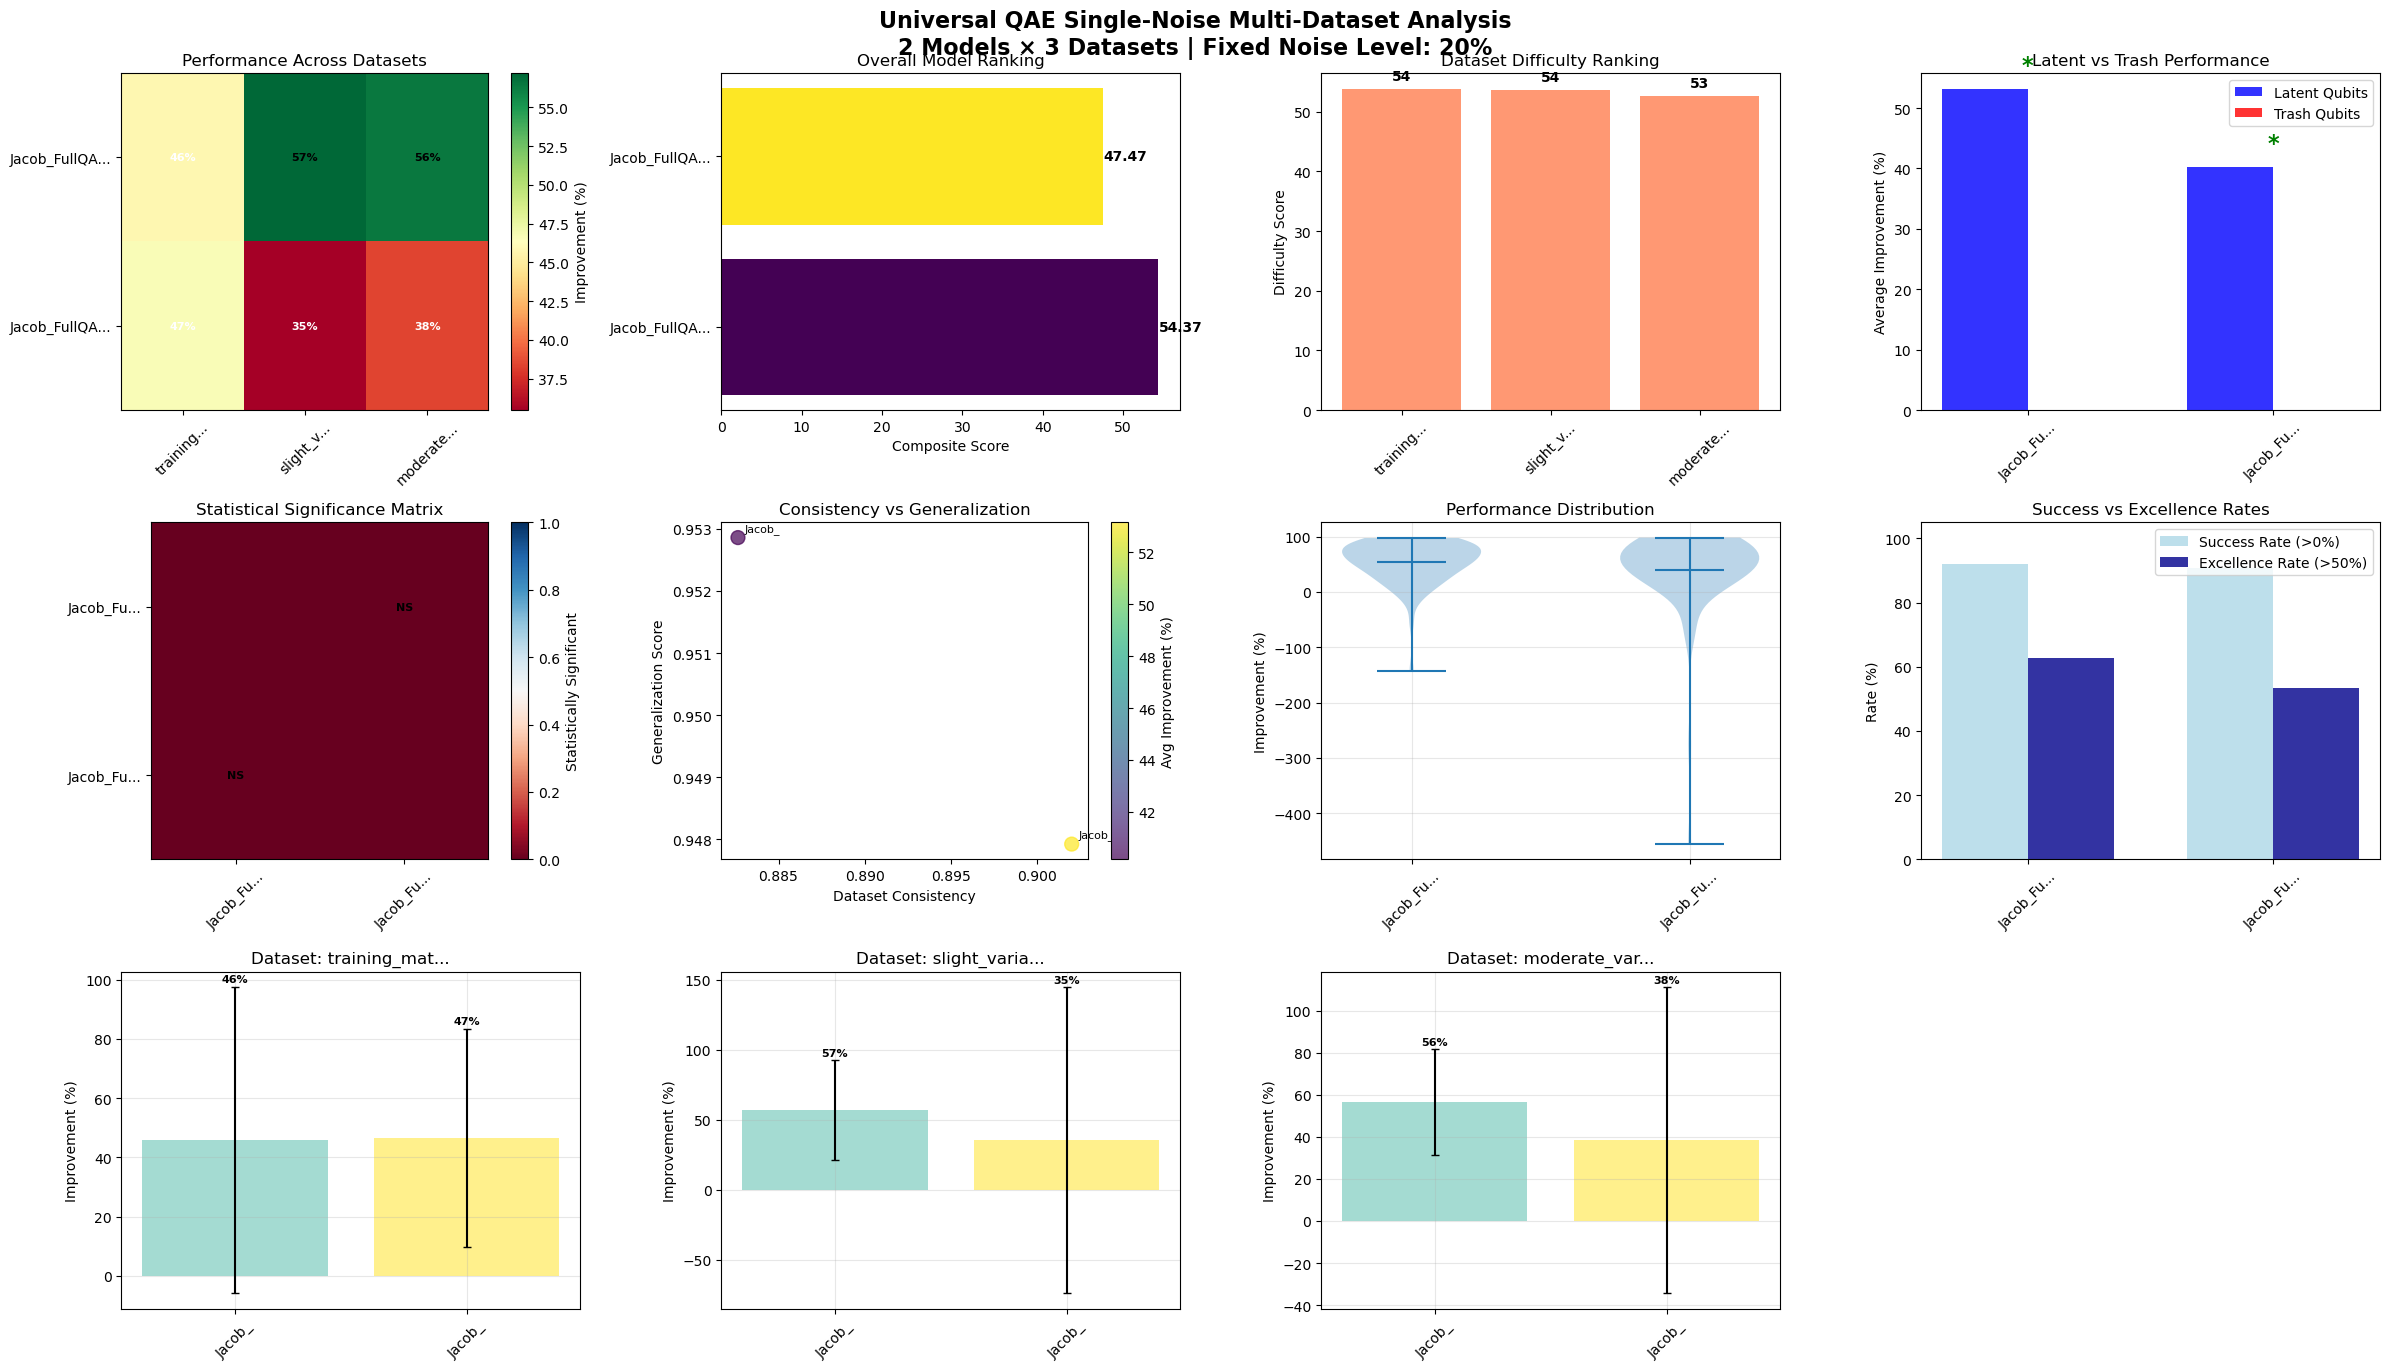


 DETAILED STATISTICAL ANALYSIS

 OVERALL MODEL PERFORMANCE:

Jacob_FullQAE_Aug03:
   • Average improvement: 53.2%
   • Success rate: 92.0%
   • Dataset consistency: 0.902
   • Generalization score: 0.948
   • Composite score: 54.368

Jacob_FullQAE_Aug08:
   • Average improvement: 40.2%
   • Success rate: 90.7%
   • Dataset consistency: 0.883
   • Generalization score: 0.953
   • Composite score: 47.475

 LATENT vs TRASH ANALYSIS:

Jacob_FullQAE_Aug03:
   • Latent improvement: 53.2%
   • Trash improvement: 0.0%
   • Latent dominance rate: 100.0%
   • Statistical significance (Mann-Whitney p): 0.000000
   • Effect size (Cohen's d): 1.907
   • Latent vs Trash difference: SIGNIFICANT

Jacob_FullQAE_Aug08:
   • Latent improvement: 40.2%
   • Trash improvement: 0.0%
   • Latent dominance rate: 100.0%
   • Statistical significance (Mann-Whitney p): 0.000000
   • Effect size (Cohen's d): 0.719
   • Latent vs Trash difference: SIGNIFICANT

 PAIRWISE MODEL COMPARISONS:

Jacob_FullQAE_Aug03 vs J

In [29]:
# Cell: Update the comparison execution with proper single-noise approach

# =============================================================================
# 🔬 RUN SINGLE-NOISE MULTI-DATASET COMPARISON
# =============================================================================

if loaded_models_count > 0:
    print("\n STARTING SINGLE-NOISE MULTI-DATASET COMPARISON")
    print("=" * 70)
    print("Focus: Dataset generalization at fixed noise level")
    print("Analysis: Comprehensive latent vs trash with p-values")
    
    # Run comparison across all datasets at single noise level
    results = framework.compare_models(
        datasets=test_datasets,  # Pass all datasets
        models_to_compare=None,  # Compare all loaded models
        n_samples=30,            # Good sample size for statistics
        noise_level=0.2,         # Single fixed noise level
        detailed_analysis=True   # Enable latent/trash analysis
    )
    
    # Generate enhanced visualization
    save_path = f"../jacobs_examples/aintern/data/mackey_glass_n100/single_noise_multi_dataset_analysis.png"
    framework.visualize_results(results, save_path)
    
    # Print detailed statistical summary
    print(f"\n DETAILED STATISTICAL ANALYSIS")
    print("=" * 70)
    
    model_names = [name for name in results.keys() if not name.startswith('_')]
    
    # Overall model performance
    print("\n OVERALL MODEL PERFORMANCE:")
    for model_name in model_names:
        overall = results[model_name]['overall_metrics']
        print(f"\n{model_name}:")
        print(f"   • Average improvement: {overall['overall_avg_improvement']:.1f}%")
        print(f"   • Success rate: {overall['overall_success_rate']:.1f}%")
        print(f"   • Dataset consistency: {overall['dataset_consistency']:.3f}")
        print(f"   • Generalization score: {overall['generalization_score']:.3f}")
        print(f"   • Composite score: {overall['composite_score']:.3f}")
    
    # Latent vs Trash Analysis
    print(f"\n LATENT vs TRASH ANALYSIS:")
    for model_name in model_names:
        lt_summary = results[model_name]['latent_trash_summary']
        if lt_summary['has_latent_analysis']:
            print(f"\n{model_name}:")
            print(f"   • Latent improvement: {lt_summary['overall_latent_improvement']:.1f}%")
            print(f"   • Trash improvement: {lt_summary['overall_trash_improvement']:.1f}%")
            print(f"   • Latent dominance rate: {lt_summary['latent_dominance_rate']:.1f}%")
            print(f"   • Statistical significance (Mann-Whitney p): {lt_summary['cross_dataset_latent_trash_mannwhitney_p']:.6f}")
            print(f"   • Effect size (Cohen's d): {lt_summary['cross_dataset_cohens_d']:.3f}")
            
            significance = "SIGNIFICANT" if lt_summary['cross_dataset_latent_trash_mannwhitney_p'] < 0.05 else "NOT SIGNIFICANT"
            print(f"   • Latent vs Trash difference: {significance}")
    
    # Statistical Comparisons
    if '_statistical_analysis' in results:
        print(f"\n PAIRWISE MODEL COMPARISONS:")
        stat_results = results['_statistical_analysis']
        
        for comparison_key, comparison_data in stat_results.items():
            model1, model2 = comparison_data['model1'], comparison_data['model2']
            overall_comp = comparison_data['overall_comparison']
            
            print(f"\n{model1} vs {model2}:")
            print(f"   • Mean difference: {overall_comp['overall_mean_difference']:.1f}%")
            print(f"   • Mann-Whitney p-value: {overall_comp['overall_mann_whitney_p']:.6f}")
            print(f"   • T-test p-value: {overall_comp['overall_t_test_p']:.6f}")
            print(f"   • Effect size: {overall_comp['overall_effect_size']} (Cohen's d: {overall_comp['overall_cohens_d']:.3f})")
            print(f"   • Winner: {overall_comp['overall_winner']}")
            print(f"   • Dataset win rate: {overall_comp['dataset_win_rate_model1']:.1f}% vs {overall_comp['dataset_win_rate_model2']:.1f}%")
            
            significance = "SIGNIFICANT" if overall_comp['overall_significant_mw'] else "NOT SIGNIFICANT"
            print(f"   • Statistical significance: {significance}")
    
    # Dataset Difficulty
    if '_dataset_analysis' in results:
        print(f"\n DATASET DIFFICULTY ANALYSIS:")
        dataset_analysis = results['_dataset_analysis']
        
        print(f"   • Most challenging: {dataset_analysis['most_challenging_dataset']}")
        print(f"   • Easiest: {dataset_analysis['easiest_dataset']}")
        print(f"   • Difficulty ranking: {', '.join(dataset_analysis['difficulty_ranking'])}")
        
        for dataset_name in dataset_analysis['difficulty_ranking']:
            diff_data = dataset_analysis['dataset_difficulty'][dataset_name]
            print(f"   • {dataset_name}: {diff_data['difficulty_score']:.1f} difficulty, "
                  f"{diff_data['discriminative_power']:.1f} discriminative power")
    
    print(f"\nSINGLE-NOISE MULTI-DATASET ANALYSIS COMPLETE!")
    print("  Enhanced visualization generated")
    print(" Comprehensive statistical analysis performed")
    print(" Detailed latent/trash comparison with p-values")
    print(" Cross-model significance testing")
    print(" Dataset difficulty assessment")
    
else:
    print("No models loaded! Please check your model paths and parameter mappings.")

In [19]:
# Add this debug cell to investigate the negative improvements
# Cell: Debug Analysis - Why Negative Improvements?

def debug_negative_improvements(results, model_name, dataset_name):
    """Debug why we're getting negative improvements"""
    
    model_results = results[model_name]['dataset_analysis'][dataset_name]
    
    print(f"\n DEBUGGING {model_name} on {dataset_name}")
    print("=" * 60)
    
    # Look at sample-level data
    sample_data = model_results['sample_data']
    
    print("Sample-by-sample analysis (first 10 samples):")
    for i, sample in enumerate(sample_data[:10]):
        print(f"Sample {i+1}:")
        print(f"   Overall: {sample['overall_improvement']:.1f}%")
        print(f"   Latent:  {sample['latent_improvement']:.1f}%") 
        print(f"   Trash:   {sample['trash_improvement']:.1f}%")
        print(f"   Overall MSE: {sample['overall_mse']:.6f}")
        print(f"   Latent MSE:  {sample['latent_mse']:.6f}")
        print(f"   Trash MSE:   {sample['trash_mse']:.6f}")
        print()
    
    # Distribution analysis
    improvements = model_results['improvements']
    print(f"Overall improvements distribution:")
    print(f"   Min: {np.min(improvements):.1f}%")
    print(f"   25th: {np.percentile(improvements, 25):.1f}%") 
    print(f"   Median: {np.median(improvements):.1f}%")
    print(f"   75th: {np.percentile(improvements, 75):.1f}%")
    print(f"   Max: {np.max(improvements):.1f}%")
    
    if 'latent_trash_analysis' in model_results:
        latent_imps = model_results['latent_trash_analysis']['latent_improvements']
        trash_imps = model_results['latent_trash_analysis']['trash_improvements']
        
        print(f"\nLatent improvements distribution:")
        print(f"   Min: {np.min(latent_imps):.1f}%")
        print(f"   Median: {np.median(latent_imps):.1f}%") 
        print(f"   Max: {np.max(latent_imps):.1f}%")
        
        print(f"\nTrash improvements distribution:")
        print(f"   Min: {np.min(trash_imps):.1f}%")
        print(f"   Median: {np.median(trash_imps):.1f}%")
        print(f"   Max: {np.max(trash_imps):.1f}%")

# Run debug analysis
debug_negative_improvements(results, 'Jacob_FullQAE_Aug08', 'training_match')
debug_negative_improvements(results, 'Jacob_FullQAE_Aug03', 'training_match')


 DEBUGGING Jacob_FullQAE_Aug08 on training_match
Sample-by-sample analysis (first 10 samples):
Sample 1:
   Overall: 78.7%
   Latent:  78.7%
   Trash:   0.0%
   Overall MSE: 0.000701
   Latent MSE:  0.000701
   Trash MSE:   nan

Sample 2:
   Overall: -14.0%
   Latent:  -14.0%
   Trash:   0.0%
   Overall MSE: 0.008020
   Latent MSE:  0.008020
   Trash MSE:   nan

Sample 3:
   Overall: 48.6%
   Latent:  48.6%
   Trash:   0.0%
   Overall MSE: 0.005647
   Latent MSE:  0.005647
   Trash MSE:   nan

Sample 4:
   Overall: 31.2%
   Latent:  31.2%
   Trash:   0.0%
   Overall MSE: 0.003380
   Latent MSE:  0.003380
   Trash MSE:   nan

Sample 5:
   Overall: 83.7%
   Latent:  83.7%
   Trash:   0.0%
   Overall MSE: 0.001752
   Latent MSE:  0.001752
   Trash MSE:   nan

Sample 6:
   Overall: 53.1%
   Latent:  53.1%
   Trash:   0.0%
   Overall MSE: 0.011500
   Latent MSE:  0.011500
   Trash MSE:   nan

Sample 7:
   Overall: 89.9%
   Latent:  89.9%
   Trash:   0.0%
   Overall MSE: 0.000629
   Latent 

In [20]:
# Cell: Check if scaling is the problem

def check_scaling_issues(framework, test_datasets):
    """Check if the scaling from quantum output to data range is working correctly"""
    
    model_name = 'Jacob_FullQAE_Aug03'
    dataset_name = 'training_match'
    
    model_info = framework.loaded_models[model_name]
    circuit = model_info['circuit']
    dataset = test_datasets[dataset_name]
    info = dataset['info']
    
    # Test with one sample
    y = dataset['y']
    pure_windows = framework._create_windows(y, 4, 1)
    test_sample = pure_windows[0]
    
    print(" SCALING DEBUG ANALYSIS")
    print("=" * 50)
    print(f"Clean target: {test_sample}")
    print(f"Data range: [{info['scale_low']:.3f}, {info['scale_high']:.3f}]")
    
    # Add noise
    data_range = info['scale_high'] - info['scale_low'] 
    noise = 0.2 * data_range * np.random.normal(size=len(test_sample))
    noisy_input = np.clip(test_sample + noise, info['scale_low'], info['scale_high'])
    print(f"Noisy input: {noisy_input}")
    
    # Get raw quantum output
    model_output_raw = circuit(noisy_input)
    print(f"Raw quantum output: {model_output_raw}")
    print(f"Raw output range: [{np.min(model_output_raw):.3f}, {np.max(model_output_raw):.3f}]")
    
    # Scaled output
    model_output = framework._scale_output(model_output_raw, info)
    print(f"Scaled model output: {model_output}")
    
    # Calculate MSEs manually
    noise_mse = np.mean((test_sample - noisy_input)**2)
    model_mse = np.mean((test_sample - model_output)**2)
    improvement = (noise_mse - model_mse) / noise_mse * 100
    
    print(f"\nMSE Analysis:")
    print(f"   Noise MSE: {noise_mse:.6f}")
    print(f"   Model MSE: {model_mse:.6f}") 
    print(f"   Improvement: {improvement:.1f}%")
    
    # Check if quantum output is stuck at boundaries
    if all(abs(val - 1.0) < 0.01 or abs(val - (-1.0)) < 0.01 for val in model_output_raw):
        print(" WARNING: Quantum output appears saturated at ±1!")
    
    return model_output_raw, model_output

check_scaling_issues(framework, test_datasets)

 SCALING DEBUG ANALYSIS
Clean target: [0.23001039 0.26468187 0.28995738 0.30838322]
Data range: [0.200, 0.800]
Noisy input: [0.2        0.2        0.38385063 0.2       ]
Raw quantum output: [tensor(-0.55574928, requires_grad=True), tensor(-0.38722453, requires_grad=True), tensor(-0.45056749, requires_grad=True), tensor(-0.486142, requires_grad=True)]
Raw output range: [-0.556, -0.387]
Scaled model output: [0.33327521598294907, 0.3838326409626901, 0.3648297515667813, 0.354157399765019]

MSE Analysis:
   Noise MSE: 0.006412
   Model MSE: 0.008140
   Improvement: -27.0%


([tensor(-0.55574928, requires_grad=True),
  tensor(-0.38722453, requires_grad=True),
  tensor(-0.45056749, requires_grad=True),
  tensor(-0.486142, requires_grad=True)],
 [0.33327521598294907,
  0.3838326409626901,
  0.3648297515667813,
  0.354157399765019])

In [22]:
# Cell: Analyze quantum output saturation across many samples

def analyze_quantum_saturation(framework, test_datasets, n_samples=50):
    """Check if quantum outputs are saturated"""
    
    model_name = 'Jacob_FullQAE_Aug03'
    dataset_name = 'training_match'
    
    model_info = framework.loaded_models[model_name]
    circuit = model_info['circuit']
    dataset = test_datasets[dataset_name]
    info = dataset['info']
    
    y = dataset['y']
    pure_windows = framework._create_windows(y, 4, 1)
    test_windows = pure_windows[:n_samples]
    
    all_raw_outputs = []
    all_improvements = []
    
    for i, clean_target in enumerate(test_windows):
        # Add noise
        data_range = info['scale_high'] - info['scale_low']
        noise = 0.2 * data_range * np.random.normal(size=len(clean_target))
        noisy_input = np.clip(clean_target + noise, info['scale_low'], info['scale_high'])
        
        # Get model output
        model_output_raw = circuit(noisy_input)
        model_output = framework._scale_output(model_output_raw, info)
        
        # Store raw outputs
        raw_vals = [float(x) for x in model_output_raw]
        all_raw_outputs.extend(raw_vals)
        
        # Calculate improvement
        noise_mse = np.mean((clean_target - noisy_input)**2)
        model_mse = np.mean((clean_target - model_output)**2)
        improvement = (noise_mse - model_mse) / noise_mse * 100
        all_improvements.append(improvement)
    
    print(f" QUANTUM OUTPUT SATURATION ANALYSIS ({n_samples} samples)")
    print("=" * 60)
    print(f"Raw quantum output statistics:")
    print(f"   Min: {np.min(all_raw_outputs):.3f}")
    print(f"   Max: {np.max(all_raw_outputs):.3f}")
    print(f"   Mean: {np.mean(all_raw_outputs):.3f}")
    print(f"   Std: {np.std(all_raw_outputs):.3f}")
    print(f"   Range used: {np.max(all_raw_outputs) - np.min(all_raw_outputs):.3f} / 2.0")
    print(f"   % of full range: {(np.max(all_raw_outputs) - np.min(all_raw_outputs)) / 2.0 * 100:.1f}%")
    
    # Check saturation
    near_minus_one = sum(1 for x in all_raw_outputs if x < -0.9) / len(all_raw_outputs) * 100
    near_plus_one = sum(1 for x in all_raw_outputs if x > 0.9) / len(all_raw_outputs) * 100
    
    print(f"\nSaturation analysis:")
    print(f"   Values near -1.0 (< -0.9): {near_minus_one:.1f}%")
    print(f"   Values near +1.0 (> 0.9): {near_plus_one:.1f}%")
    print(f"   Stuck in middle range: {100 - near_minus_one - near_plus_one:.1f}%")
    
    if near_minus_one + near_plus_one < 10:
        print(" WARNING: Model is NOT using the full quantum range!")
        print("   This suggests gradient vanishing or poor training.")
    
    print(f"\nPerformance correlation:")
    print(f"   Improvement statistics: {np.mean(all_improvements):.1f}% ± {np.std(all_improvements):.1f}%")
    print(f"   Positive improvements: {sum(1 for x in all_improvements if x > 0) / len(all_improvements) * 100:.1f}%")
    
    return all_raw_outputs, all_improvements

analyze_quantum_saturation(framework, test_datasets)

 QUANTUM OUTPUT SATURATION ANALYSIS (50 samples)
Raw quantum output statistics:
   Min: -0.571
   Max: 0.724
   Mean: 0.159
   Std: 0.405
   Range used: 1.295 / 2.0
   % of full range: 64.8%

Saturation analysis:
   Values near -1.0 (< -0.9): 0.0%
   Values near +1.0 (> 0.9): 0.0%
   Stuck in middle range: 100.0%
   This suggests gradient vanishing or poor training.

Performance correlation:
   Improvement statistics: 18.8% ± 146.9%
   Positive improvements: 80.0%


([-0.3485091233927991,
  -0.5034554785587245,
  -0.43307180003488766,
  -0.20492862877124002,
  -0.4917176679118138,
  -0.5283900769185793,
  -0.49804420280890216,
  -0.1763339773346665,
  -0.5286395561691554,
  -0.37810465559909984,
  -0.30831806823303853,
  -0.2805897187976303,
  -0.29495579274644473,
  -0.37823121019872225,
  -0.3795936020394029,
  -0.3752629099791348,
  -0.5548471352659763,
  -0.47061099123510375,
  -0.47181761899881214,
  -0.4241406587963074,
  -0.5182867622557255,
  -0.505707463993355,
  -0.45180845135063347,
  -0.1900578828450959,
  -0.5711310494121292,
  -0.5324507690422453,
  -0.4888584281266044,
  -0.2550810491855481,
  -0.4336319075087534,
  -0.4134606485971609,
  -0.3426708090344922,
  -0.23726489292203834,
  0.17611270344440172,
  -0.07503073661236825,
  -0.2755181403581015,
  -0.29972219223598945,
  -0.5193130200000944,
  -0.423622069943673,
  -0.3911947295596949,
  -0.35611354817709623,
  -0.026879007934807853,
  -0.1536850547467698,
  -0.276070330769366

In [30]:
# Check parameter distribution
model_info = framework.loaded_models['Jacob_FullQAE_Aug03']
params = model_info['parameters']
print(f"Encoder params shape: {np.array(params['encoder_params']).shape}")
print(f"Decoder params shape: {np.array(params['decoder_params']).shape}")
print(f"Total params: {len(params['encoder_params']) + len(params['decoder_params'])}")

# For 4+0 architecture: expect 48 total params (2 layers × 4 qubits × 3 rotations × 2 circuits)
# For 2+2 architecture: expect different

Encoder params shape: (24,)
Decoder params shape: (24,)
Total params: 48
